In [148]:
# magic lines that avoid re-start 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [149]:
import pybamm as pb;import pandas as pd   ;import numpy as np;
import os;
import matplotlib.pyplot as plt;import os;#import imageio
from scipy.io import savemat,loadmat;from pybamm import constants,exp;import matplotlib as mpl; fs=17; # or we can set import matplotlib.pyplot as plt then say 'mpl.rc...'
import openpyxl
import traceback
import multiprocessing
import scipy.optimize
import timeit
import random;import time, signal
fs=17;
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)
import sys  
str_path_0 = os.path.abspath(os.path.join(pb.__path__[0],'..'))
str_path_1 = os.path.abspath(os.path.join(str_path_0,"wip\Rio_Code\Fun_P2"))
sys.path.append(str_path_1) 
from Fun_P2 import *

In [150]:
########################  Input  ########################
# all values here must be a list, even it is a single object
Para_dict_All = {
   "Ageing temperature":[10,25,40], # 25, 40 
   "Total ageing cycles":[9,], # 6192
   "Ageing cycles between RPT":[3,], # 516
   "Update cycles for ageing": [3,],
   "Cycles within RPT":[1,],
   
   "RPT temperature":[25,],
   "Mesh list":[[5,5,5,60,20],],   # Simon uses 30
   "Para_Set":[ "OKane2023",], # Li2023_Coupled
   "Model option":[
      {
         "contact resistance": "true",
         "open-circuit potential": "current sigmoid",
         "thermal": "lumped",
         "SEI": "interstitial-diffusion limited",
         "SEI on cracks": "true",
         "SEI film resistance": "distributed", 
         "SEI porosity change": "true",
         "particle mechanics": ("swelling and cracking", "swelling only"),
         "loss of active material": "stress-driven",
         "lithium plating": "partially reversible",
      },
      ],
   #"Inner SEI reaction proportion":[0.5,],
   #"Ratio of lithium moles to SEI moles":[2,], # I have always been using 1 for solvent consumption model
   #"Initial inner SEI thickness [m]":[1.2362e-08,],
   #"Initial outer SEI thickness [m]":[1.2362e-08,],
   "Contact resistance [Ohm]": [0.0105,],
   "Electrolyte conductivity [S.m-1]":[
      "electrolyte_conductivity_EC_EMC_3_7_Landesfeind2019_Constant",
      ],
    "Electrolyte diffusivity [m2.s-1]":[
      "electrolyte_diffusivity_EC_EMC_3_7_Landesfeind2019_Constant",],
   "Thermodynamic factor":[
      "electrolyte_TDF_EC_EMC_3_7_Landesfeind2019_Constant",
      ],
    "Cation transference number":[
      "electrolyte_transference_number_EC_EMC_3_7_Landesfeind2019_Constant",],
   # Solvent consumption sub-model
   "Initial electrolyte excessive amount ratio":[ 0.5,1.2], # set to <1 for DryOut=Off 
   "Current solvent concentration in the reservoir [mol.m-3]":[4541.0,],
   "Current electrolyte concentration in the reservoir [mol.m-3]":[1000,],
   "Ratio of Li-ion concentration change in electrolyte consider solvent consumption":[1.0,],
   # DFN parameter
   "Upper voltage cut-off [V]":[4.4,],
   "Lower voltage cut-off [V]":[2.4,],

   # interstitial-diffusion limited
   'Inner SEI lithium interstitial diffusivity [m2.s-1]':[3e-20,],    
   'Lithium interstitial reference concentration [mol.m-3]':[15,],
   # ec-reaction limited
   'EC diffusivity [m2.s-1]':[1e-22,],
   'SEI kinetic rate constant [m.s-1]':[1e-12,], 
   'EC initial concentration in electrolyte [mol.m-3]':[4541.0,],
   'Typical EC concentration in electrolyte [mol.m-3]':[4541.0,], # Mark Ruihe change, act as an initial value here
   # LiP and coupling with SEI:
   "Dead lithium decay constant [s-1]":[ 1e-6,],            # default: 1e-6
   'Lithium plating kinetic rate constant [m.s-1]':[1E-10], # default: 1e-9
   # Crack model
   "Negative electrode LAM constant proportional term [s-1]":[ 5e-8], # default: 2.7778e-07
   "Positive electrode LAM constant proportional term [s-1]":[ 5e-8,], # default: 2.7778e-07
   # make it simple for now,], but may want to have T dependency in the future
   "Negative electrode cracking rate":[ 1e-22,],   # default: function, ~3.9e-20
   #"Positive electrode cracking rate":[ 1e-22,],   # default: function, ~3.9e-20
   #"Negative electrode volume change":[ 0.0,],
   #"Positive electrode volume change":[ 0.0,],
   #"Initial Neg SOC":[0.850],    #list(np.linspace(0.84,0.90,6)),
   #"Initial Pos SOC":[0.2705], # list(np.linspace(0.22,0.27,6)),
}
Para_dict_list = []
recursive_scan(Para_dict_list,Para_dict_All, list(Para_dict_All.keys()), {})
print(f"Total scan case is {len(Para_dict_list)}")

Total scan case is 6


In [151]:
# Set Experiment : Exp-2
index_exp = 2 # index for experiment set, can now go for 2,3,5

In [152]:
BasicPath = 'D:/OneDrive - Imperial College London/SimDataSave/P2_R8_FromSimon'; 
#BasicPath=os.getcwd()
Target  = '/Exp2_9cycles/'
if not os.path.exists(BasicPath + Target):
   os.mkdir(BasicPath + Target);
if not os.path.exists(BasicPath + Target+"Mats"):
   os.mkdir(BasicPath + Target+"Mats");
if not os.path.exists(BasicPath + Target+"Plots"):
   os.mkdir(BasicPath + Target+"Plots");
if not os.path.exists(BasicPath + Target+"Excel"):
   os.mkdir(BasicPath + Target+"Excel");
book_name_xlsx = 'Exp2_9cycles.xlsx';
sheet_name_xlsx = 'Results';
Path_pack = [BasicPath,Target,book_name_xlsx,sheet_name_xlsx,];


V_max = 4.2;        V_min = 2.5; 
discharge_time_mins = 0.15* 60 * 4.86491/5
charge_time_mins = 0.5* 60 * 4.86491/5
exp_AGE_text = [(
    f"Discharge at 1C for {discharge_time_mins} minutes or until {V_min}V", 
    f"Charge at 0.3C for {charge_time_mins} minutes or until {V_max}V",
    ),  ]  # *  setting on cycler is 516, rather than 514 in wiki
# step index for ageing
step_AGE_CD =0;   step_AGE_CC =1;   step_AGE_CV =2;

exp_RPT_text = [ (
    # refill
    f"Hold at {V_max}V until C/100",
    "Rest for 1 hours (20 minute period)", 
    # 0.1C cycle 
    f"Discharge at 0.1C until {V_min} V (30 minute period)",  
    "Rest for 3 hours (20 minute period)",  
    f"Charge at 0.1C until {V_max} V (30 minute period)",
    f"Hold at {V_max}V until C/100",
    "Rest for 1 hours (20 minute period)",
    # 0.5C cycle 
    f"Discharge at 0.5C until {V_min} V (6 minute period)",  
    "Rest for 3 hours (20 minute period)",
    f"Charge at 0.5C until {V_max} V (6 minute period)",
    f"Hold at {V_max}V until C/100",
    "Rest for 3 hours (20 minute period)",  
    ) ] * 1
# step index for RPT
step_0p1C_CD = 2; step_0p1C_CC = 4;   step_0p1C_RE =3;    
step_0p5C_CD = 7;  

exp_text_list = [exp_AGE_text,  exp_RPT_text     ];
cycle_no = -1; 
exp_index_pack = [cycle_no,step_AGE_CD,step_AGE_CC,step_AGE_CV,
   step_0p1C_CD, step_0p1C_CC,step_0p1C_RE , step_0p5C_CD ];


In [153]:
# define global index and dict for all experiment data - prepare for read!
Exp_Path = [
    "Expt 1 - Si-based Degradation/",
    "Expt 2,2 - C-based Degradation 2/",
    "Expt 3 - Cathode Degradation and Li-Plating/",
    "Expt 4 - Drive Cycle Aging (Control)/",
    "Expt 5 - Standard Cycle Aging (Control)/",]
Exp_head = [
    "Expt 1",
    "Expt 2,2",
    "Expt 3",
    "Expt 4",
    "Expt 5",]
Exp_1_Cell = ["A","B","J","D","E","F","K","L","M"];
Exp_1_Temp = {
    "A":"10","B":"10","J":"10",
    "D":"25","E":"25","F":"25",
    "K":"40","L":"40","M":"40",}
Temp_Cell_Exp_1 = {
    "10":["A","B","J"],
    "25":["D","E","F"],
    "40":["K","L","M"],}
Exp_2_Cell = ["A","B","C","D","E","F"];
Exp_2_Temp = {
    "A":"10","B":"10",
    "C":"25","D":"25",
    "E":"40","F":"40",}
Temp_Cell_Exp_2 = {
    "10":["A","B"],
    "25":["C","D"],
    "40":["E","F"],}
Exp_3_Cell = ["A","B","C","D","E","F","G","H","I"];
Exp_3_Temp = {
    "A":"10","B":"10","C":"10",
    "D":"25","E":"25","F":"25",
    "G":"40","H":"40","I":"40"}
Temp_Cell_Exp_3 = {
    "10":["A","B","C"],
    "25":["D","E","F"],
    "40":["G","H","I"],}
Exp_4_Cell = ["A","B","C","D","E","F","G","H"];
Exp_4_Temp = {
    "A":"10","B":"10","C":"10",
    "D":"25","E":"25",
    "F":"40","G":"40","H":"40",}
Temp_Cell_Exp_4 = {
    "10":["A","B","C"],
    "25":["D","E",],
    "40":["F","G","H"],}
Exp_5_Cell = ["A","B","C","D","E","F","G","H"];
Exp_5_Temp = {
    "A":"10","B":"10","C":"10",
    "D":"25","E":"25",
    "F":"40","G":"40","H":"40",}
Temp_Cell_Exp_5 = {
    "10":["A","B","C"],
    "25":["D","E",],
    "40":["F","G","H"],}
Exp_All_Cell  = [Exp_1_Cell,Exp_2_Cell,Exp_3_Cell,Exp_4_Cell,Exp_5_Cell]
Exp_Temp_Cell = [Exp_1_Temp,Exp_2_Temp,Exp_3_Temp,Exp_4_Temp,Exp_5_Temp]
Temp_Cell_Exp_All = [Temp_Cell_Exp_1,Temp_Cell_Exp_2,Temp_Cell_Exp_3,Temp_Cell_Exp_4,Temp_Cell_Exp_5]
Mark_Cell_All = [
    {
    "A":"o","B":">","J":"v",
    "D":"o","E":">","F":"v",
    "K":"o","L":">","M":"v",},
    {
    "A":"10","B":"10",
    "C":"25","D":"25",
    "E":"40","F":"40",},
    {
    "A":"o","B":">","C":"v",
    "D":"o","E":">","F":"v",
    "G":"o","H":">","I":"v",},
    {
    "A":"o","B":">","C":"v",
    "D":"o","E":">",
    "F":"o","G":">","H":"v",},
    {
    "A":"o","B":">","C":"v",
    "D":"o","E":">",
    "F":"o","G":">","H":"v",}]
Color_Cell_All = [
    {
    "A":[2/255, 3/255, 226/255,0.7],"B":[2/255, 3/255, 226/255,0.7],"J":[2/255, 3/255, 226/255,0.7],
    "D":[0, 0, 0,0.7],"E":[0, 0, 0,0.7],"F":[0, 0, 0,0.7],
    "K":[1,0,0,0.4],"L":[1,0,0,0.4],"M":[1,0,0,0.4],},
    {
    "A":[2/255, 3/255, 226/255,0.7],"B":[2/255, 3/255, 226/255,0.7],
    "D":[0, 0, 0,0.7],"C":[0, 0, 0,0.7],
    "E":[1,0,0,0.4],"F":[1,0,0,0.4],},
    {
    "A":[2/255, 3/255, 226/255,0.7],"B":[2/255, 3/255, 226/255,0.7],"C":[2/255, 3/255, 226/255,0.7],
    "D":[0, 0, 0,0.7],"E":[0, 0, 0,0.7],"F":[0, 0, 0,0.7],
    "G":[1,0,0,0.4],"H":[1,0,0,0.4],"I":[1,0,0,0.4],},
    {
    "A":[2/255, 3/255, 226/255,0.7],"B":[2/255, 3/255, 226/255,0.7],"C":[2/255, 3/255, 226/255,0.7],
    "D":[0, 0, 0,0.7],"E":[0, 0, 0,0.7],
    "F":[1,0,0,0.4],"G":[1,0,0,0.4],"H":[1,0,0,0.4],},
    {
    "A":[2/255, 3/255, 226/255,0.7],"B":[2/255, 3/255, 226/255,0.7],"C":[2/255, 3/255, 226/255,0.7],
    "D":[0, 0, 0,0.7],"E":[0, 0, 0,0.7],
    "F":[1,0,0,0.4],"G":[1,0,0,0.4],"H":[1,0,0,0.4],}]


In [154]:
########################  Output  ########################
keys_loc_RPT = [ # MAY WANT TO SELECT AGEING CYCLE later
    # Default output:
    "x [m]",
    "x_n [m]",
    "x_s [m]",
    "x_p [m]",
    # default: end; 
    "CCend Porosity",
    "CCend Negative electrode interfacial current density [A.m-2]",
    "CCend Electrolyte potential [V]",
    "CCend Electrolyte concentration [mol.m-3]",
    "CCend Negative electrode reaction overpotential [V]",
    "CCend Negative particle surface concentration [mol.m-3]",
    "CCend Negative electrode roughness ratio",
    "CCend Total SEI on cracks thickness [m]",

    "CDend Porosity",
    "CDend Negative electrode interfacial current density [A.m-2]",
    "CDend Electrolyte potential [V]",
    "CDend Electrolyte concentration [mol.m-3]",
    "CDend Negative electrode reaction overpotential [V]",
    "CDend Negative particle surface concentration [mol.m-3]",
    "CDend Negative electrode roughness ratio",
    "CDend Total SEI on cracks thickness [m]",
    #"REend Total SEI on cracks thickness [m]",
]
keys_tim_RPT = [
    # default: CD
    "CD Time [h]",
    "CD Terminal voltage [V]",
    #"RE Terminal voltage [V]",
]
keys_cyc_RPT = [   # default: CDend
    "Discharge capacity [A.h]",
    "Throughput capacity [A.h]",
    "CDend Total lithium capacity in particles [A.h]",
    "CDend Loss of capacity to lithium plating [A.h]",
    "CDend Loss of capacity to SEI [A.h]",
    "CDend Loss of capacity to SEI on cracks [A.h]",
    "CDend X-averaged total SEI on cracks thickness [m]",
    "CDend X-averaged negative electrode roughness ratio",
    "CDend Local ECM resistance [Ohm]",
    "CDsta Negative electrode stoichiometry", 
    "CDend Negative electrode stoichiometry",
    "CDsta Positive electrode stoichiometry", 
    "CDend Positive electrode stoichiometry",
    "CDend Negative electrode capacity [A.h]",
    "CDend Positive electrode capacity [A.h]",
    
]

keys_loc_AGE = [ # MAY WANT TO SELECT AGEING CYCLE later
    # Default output:
    "x [m]",
    "x_n [m]",
    "x_s [m]",
    "x_p [m]",
    # default: end; 
    "CCend Porosity",
    "CCend Negative electrode interfacial current density [A.m-2]",
    "CCend Electrolyte potential [V]",
    "CCend Electrolyte concentration [mol.m-3]",
    "CCend Negative electrode reaction overpotential [V]",
    "CCend Negative particle surface concentration [mol.m-3]",
    "CCend Negative electrode roughness ratio",
    "CCend Total SEI on cracks thickness [m]",

    "CDend Porosity",
    "CDend Negative electrode interfacial current density [A.m-2]",
    "CDend Electrolyte potential [V]",
    "CDend Electrolyte concentration [mol.m-3]",
    "CDend Negative electrode reaction overpotential [V]",
    "CDend Negative particle surface concentration [mol.m-3]",
    "CDend Negative electrode roughness ratio",
    "CDend Total SEI on cracks thickness [m]",
    "CDend Electrolyte diffusivity [m2.s-1]",
    "CDend Electrolyte conductivity [S.m-1]",
]
keys_tim_AGE = [];
keys_cyc_AGE = [];
keys_all_RPT = [keys_loc_RPT,keys_tim_RPT,keys_cyc_RPT];
keys_all_AGE = [keys_loc_AGE,keys_tim_AGE,keys_cyc_AGE];
keys_all = [keys_all_RPT,keys_all_AGE];


In [162]:
# Write para - 1st round:
Values_1 = []
head_keys = list(Para_dict_list[0].keys())
head_pre = [
    "Scan No","Exp No.","Y or N",
    "Error Tot%","Error SOH %","Error LLI %",
    "Error LAM NE %","Error LAM PE %","Error Res %","Dry out"]

head_pos = [ "exp_AGE_text", "exp_RPT_text",
   "Cap Loss","LLI to LiP",
   "LLI to SEI","LLI to sei-on-cracks",
   "LAM to Neg","LAM to Pos",
   "Vol_Elely_Tot Final", "Vol_Elely_JR Final","Width Final","Error"]
Values_1 .append([*head_pre,*head_keys,*head_pos])
index_list = np.arange(1,len(Para_dict_list)+1,1)
for Scan_i,Para_dict_i in zip(index_list,Para_dict_list):
    value_list_temp = list(Para_dict_i.values())
    values_para = []
    for value_list_temp_i in value_list_temp:
        values_para.append(str(value_list_temp_i))
    # sequence: scan no, exp, pass or fail, mpe, dry-out, 
    mpe_all = ["Unknown","Unknown",
        "Unknown","Unknown", 
        "Unknown","Unknown",]
    Pass_Fail = "Unknown"
    DryOut = "Unknown"
    value_Pre = [str(Scan_i),index_exp,Pass_Fail,*mpe_all,DryOut,]
    values = [*value_Pre,*values_para,]
    Values_1.append(values)
write_excel_xlsx(
    BasicPath + Target+book_name_xlsx, 
    sheet_name_xlsx, Values_1)   


Successfully create a excel file


In [156]:
# Global path 
# Path_NiallDMA = "InputData/" # for HPC
Path_NiallDMA = "D:/OneDrive - Imperial College London/SimDataSave/InputData/"
#D:\OneDrive - Imperial College London\SimDataSave\InputData\Expt 4 - Drive Cycle Aging (Control) 
Temp_Cell_Exp = Temp_Cell_Exp_All[index_exp-1] # select a cell list through temperature
Exp_Any_AllData = Read_Exp(
    Path_NiallDMA,Exp_All_Cell[index_exp-1],
    Exp_Path,Exp_head,Exp_Temp_Cell[index_exp-1],
    index_exp-1)


Finish reading Experiment!


Start Now! Scan 1.
Scan 1: DryOut = Off
Scan 1: Spent 1.227 ms on Initialization


At t = 1302.79 and h = 2.3627e-13, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 1: Finish break-in cycle within 1 minute, 23 seconds
Scan 1: Finish post-process for break-in cycle within 172.776 ms
Scan 1: Finish for No.0 ageing cycles within 13.601 s
Scan 1: Finish post-process for No.3 ageing cycles within 95.684 ms


At t = 1236.17 and h = 5.47454e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 1: Finish for No.3 RPT cycles within 1 minute, 24 seconds
Scan 1: Finish post-process for No.3 RPT cycles within 118.182 ms
Scan 1: Finish for No.3 ageing cycles within 15.008 s
Scan 1: Finish post-process for No.6 ageing cycles within 61.951 ms


At t = 1203.79 and h = 7.43554e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 1: Finish for No.6 RPT cycles within 1 minute, 28 seconds
Scan 1: Finish post-process for No.6 RPT cycles within 116.484 ms
Scan 1: Finish for No.6 ageing cycles within 15.690 s
Scan 1: Finish post-process for No.9 ageing cycles within 59.152 ms


At t = 1172.38 and h = 7.6213e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 1: Finish for No.9 RPT cycles within 1 minute, 28 seconds
Scan 1: Finish post-process for No.9 RPT cycles within 115.592 ms
Scan 1: Getting extra variables within 254.200 us
Scan 1: Finish all plots within 4.273 s
Successfully create a excel file
Scan 1: Finish saving mat and xlsx within 22.293 ms
Succeed doing something in 6 minutes, 32 seconds
This is the end of No. 1  scan
Start Now! Scan 2.
Scan 2: DryOut = On
Initial electrolyte amount is  6.051659553969119 mL
Scan 2: Spent 577.200 us on Initialization


At t = 1302.84 and h = 3.40649e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 2: Finish break-in cycle within 1 minute, 23 seconds
Scan 2: Finish post-process for break-in cycle within 167.939 ms
Scan 2: Finish for No.0 ageing cycles within 15.620 s
Scan 2: Finish post-process for No.3 ageing cycles within 96.642 ms


At t = 1236.17 and h = 3.3614e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 2: Finish for No.3 RPT cycles within 1 minute, 28 seconds
Scan 2: Finish post-process for No.3 RPT cycles within 118.321 ms
Scan 2: Finish for No.3 ageing cycles within 15.160 s
Scan 2: Finish post-process for No.6 ageing cycles within 53.463 ms


At t = 1203.77 and h = 9.29758e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 2: Finish for No.6 RPT cycles within 1 minute, 24 seconds
Scan 2: Finish post-process for No.6 RPT cycles within 121.505 ms
Scan 2: Finish for No.6 ageing cycles within 15.047 s
Scan 2: Finish post-process for No.9 ageing cycles within 50.121 ms


At t = 1172.36 and h = 8.16769e-12, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 2: Finish for No.9 RPT cycles within 1 minute, 51 seconds
Scan 2: Finish post-process for No.9 RPT cycles within 110.469 ms
Scan 2: Getting extra variables within 256.800 us
Scan 2: Finish all plots within 4.686 s
Successfully create a excel file
Scan 2: Finish saving mat and xlsx within 20.910 ms
Succeed doing something in 6 minutes, 59 seconds
This is the end of No. 2  scan
Start Now! Scan 3.
Scan 3: DryOut = Off
Scan 3: Spent 415.900 us on Initialization


At t = 1302.84 and h = 6.95483e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 3: Finish break-in cycle within 1 minute, 23 seconds
Scan 3: Finish post-process for break-in cycle within 170.001 ms
Scan 3: Finish for No.0 ageing cycles within 15.066 s
Scan 3: Finish post-process for No.3 ageing cycles within 93.353 ms


At t = 1235.09 and h = 4.70833e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 3: Finish for No.3 RPT cycles within 1 minute, 22 seconds
Scan 3: Finish post-process for No.3 RPT cycles within 118.500 ms
Scan 3: Finish for No.3 ageing cycles within 13.202 s
Scan 3: Finish post-process for No.6 ageing cycles within 58.782 ms


At t = 1203.15 and h = 3.19909e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 3: Finish for No.6 RPT cycles within 1 minute, 23 seconds
Scan 3: Finish post-process for No.6 RPT cycles within 115.148 ms
Scan 3: Finish for No.6 ageing cycles within 13.979 s
Scan 3: Finish post-process for No.9 ageing cycles within 50.987 ms


At t = 1172.24 and h = 7.18079e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 3: Finish for No.9 RPT cycles within 1 minute, 24 seconds
Scan 3: Finish post-process for No.9 RPT cycles within 117.306 ms
Scan 3: Getting extra variables within 447.900 us
Scan 3: Finish all plots within 4.322 s
Successfully create a excel file
Scan 3: Finish saving mat and xlsx within 20.425 ms
Succeed doing something in 6 minutes, 19 seconds
This is the end of No. 3  scan
Start Now! Scan 4.
Scan 4: DryOut = On
Initial electrolyte amount is  6.051659553969119 mL
Scan 4: Spent 469.400 us on Initialization


At t = 1302.84 and h = 4.16165e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 4: Finish break-in cycle within 1 minute, 24 seconds
Scan 4: Finish post-process for break-in cycle within 178.387 ms
Scan 4: Finish for No.0 ageing cycles within 14.487 s
Scan 4: Finish post-process for No.3 ageing cycles within 95.763 ms


At t = 1235.06 and h = 3.65602e-13, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 4: Finish for No.3 RPT cycles within 1 minute, 22 seconds
Scan 4: Finish post-process for No.3 RPT cycles within 118.592 ms
Scan 4: Finish for No.3 ageing cycles within 13.764 s
Scan 4: Finish post-process for No.6 ageing cycles within 48.662 ms


At t = 1203.14 and h = 1.05854e-10, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 4: Finish for No.6 RPT cycles within 1 minute, 25 seconds
Scan 4: Finish post-process for No.6 RPT cycles within 120.826 ms
Scan 4: Finish for No.6 ageing cycles within 15.708 s
Scan 4: Finish post-process for No.9 ageing cycles within 59.457 ms


At t = 1172.22 and h = 4.16202e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 4: Finish for No.9 RPT cycles within 1 minute, 29 seconds
Scan 4: Finish post-process for No.9 RPT cycles within 121.786 ms
Scan 4: Getting extra variables within 421.500 us
Scan 4: Finish all plots within 8.549 s
Successfully create a excel file
Scan 4: Finish saving mat and xlsx within 22.351 ms
Succeed doing something in 6 minutes, 33 seconds
This is the end of No. 4  scan
Start Now! Scan 5.
Scan 5: DryOut = Off
Scan 5: Spent 436.300 us on Initialization


At t = 1302.84 and h = 6.50926e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 5: Finish break-in cycle within 1 minute, 25 seconds
Scan 5: Finish post-process for break-in cycle within 171.985 ms
Scan 5: Finish for No.0 ageing cycles within 12.652 s
Scan 5: Finish post-process for No.3 ageing cycles within 95.791 ms


At t = 1231.57 and h = 6.51157e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 5: Finish for No.3 RPT cycles within 1 minute, 27 seconds
Scan 5: Finish post-process for No.3 RPT cycles within 112.692 ms
Scan 5: Finish for No.3 ageing cycles within 14.530 s
Scan 5: Finish post-process for No.6 ageing cycles within 60.986 ms


At t = 1199.55 and h = 4.35438e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 5: Finish for No.6 RPT cycles within 1 minute, 23 seconds
Scan 5: Finish post-process for No.6 RPT cycles within 123.414 ms
Scan 5: Finish for No.6 ageing cycles within 13.249 s
Scan 5: Finish post-process for No.9 ageing cycles within 57.867 ms


At t = 1168.66 and h = 2.26598e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 5: Finish for No.9 RPT cycles within 1 minute, 28 seconds
Scan 5: Finish post-process for No.9 RPT cycles within 108.754 ms
Scan 5: Getting extra variables within 561.700 us
Scan 5: Finish all plots within 4.087 s
Successfully create a excel file
Scan 5: Finish saving mat and xlsx within 18.839 ms
Succeed doing something in 6 minutes, 28 seconds
This is the end of No. 5  scan
Start Now! Scan 6.
Scan 6: DryOut = On
Initial electrolyte amount is  6.051659553969119 mL
Scan 6: Spent 467.200 us on Initialization


At t = 1302.84 and h = 8.22378e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 6: Finish break-in cycle within 1 minute, 22 seconds
Scan 6: Finish post-process for break-in cycle within 168.433 ms
Scan 6: Finish for No.0 ageing cycles within 13.919 s
Scan 6: Finish post-process for No.3 ageing cycles within 97.254 ms


At t = 1231.56 and h = 3.73466e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 6: Finish for No.3 RPT cycles within 1 minute, 24 seconds
Scan 6: Finish post-process for No.3 RPT cycles within 122.241 ms
Scan 6: Finish for No.3 ageing cycles within 13.632 s
Scan 6: Finish post-process for No.6 ageing cycles within 58.640 ms


At t = 1199.52 and h = 1.5067e-13, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 6: Finish for No.6 RPT cycles within 1 minute, 23 seconds
Scan 6: Finish post-process for No.6 RPT cycles within 108.686 ms
Scan 6: Finish for No.6 ageing cycles within 12.811 s
Scan 6: Finish post-process for No.9 ageing cycles within 49.540 ms
Electrolyte is being squeezed out, check plated lithium (reversible part)


At t = 1168.64 and h = 9.08944e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 6: Finish for No.9 RPT cycles within 1 minute, 24 seconds
Scan 6: Finish post-process for No.9 RPT cycles within 123.098 ms
Scan 6: Getting extra variables within 686.400 us
Scan 6: Finish all plots within 4.669 s
Successfully create a excel file
Scan 6: Finish saving mat and xlsx within 20.011 ms
Succeed doing something in 6 minutes, 19 seconds
This is the end of No. 6  scan


' if __name__ == "__main__":\n    pool = multiprocessing.Pool(24)\n    processes = [\n        pool.apply_async(\n            Run_P2_Opt_Timeout, \n            args=(\n                index_i, Para_dict_i,   Path_pack,fs,\n                keys_all,   exp_text_list, exp_index_pack,\n                Exp_Any_AllData,Temp_Cell_Exp,\n                True,False,False,) #Plot_Exp,  Timeout,Return_Sol \n            ) \n            for index_i, Para_dict_i in zip(index_list,Para_dict_list)]\n    result = [p.get() for p in processes]   '

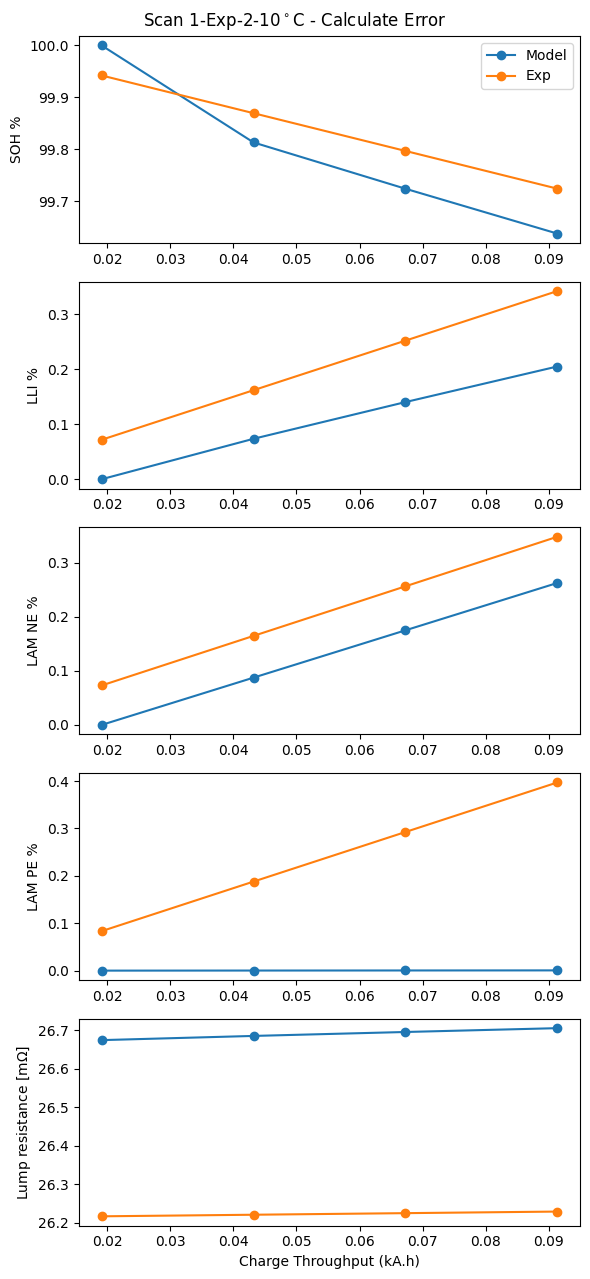

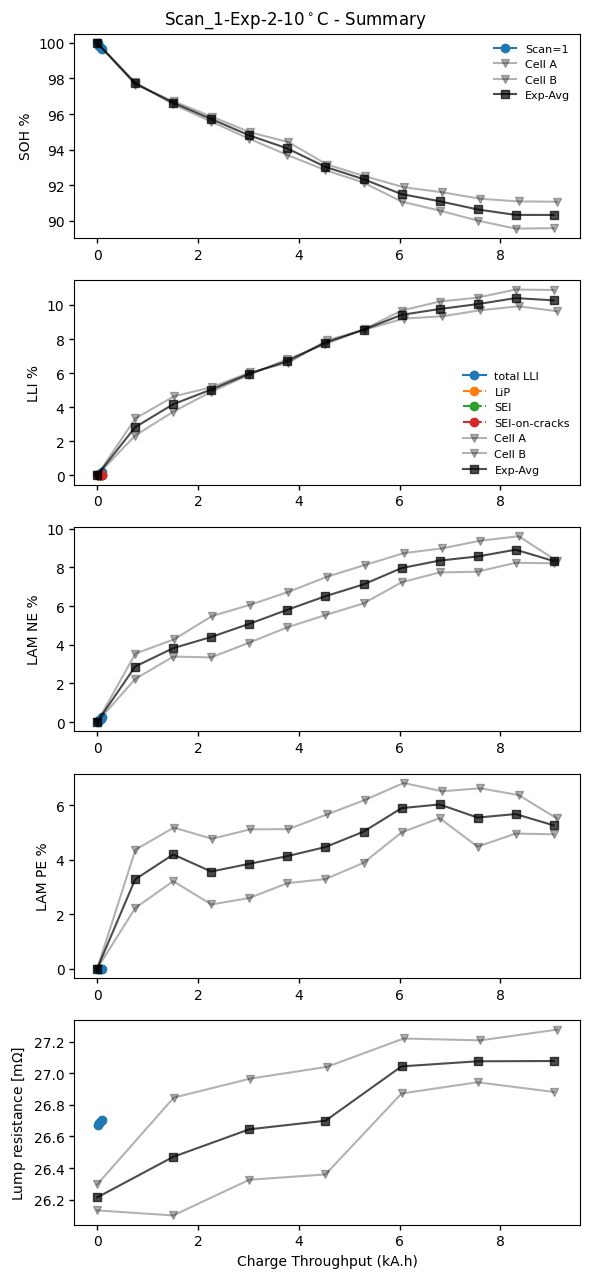

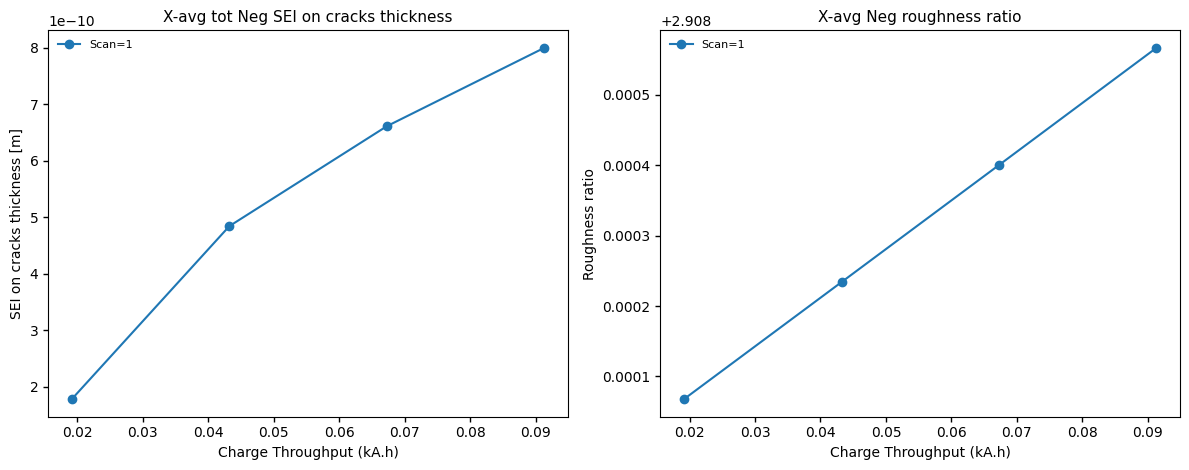

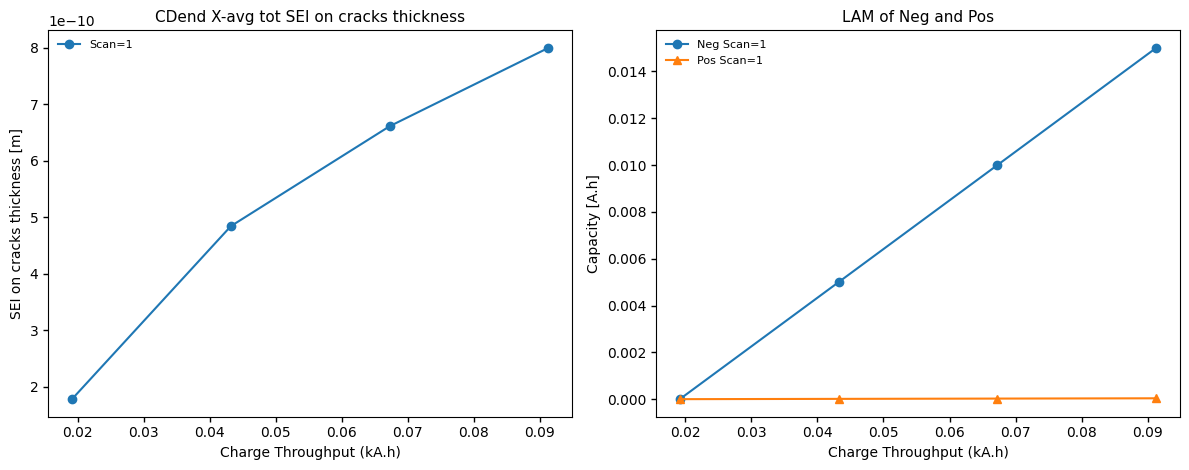

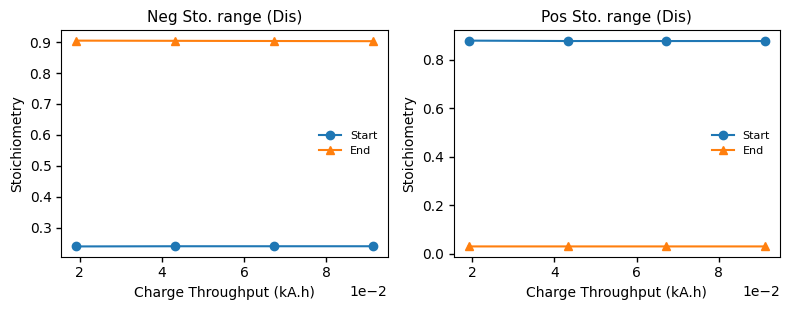

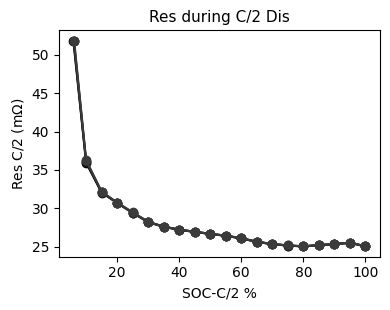

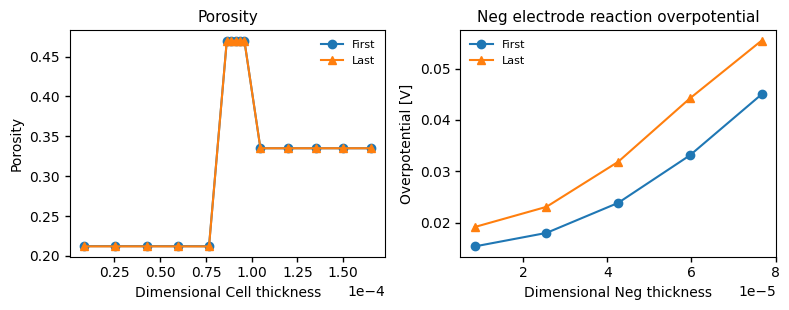

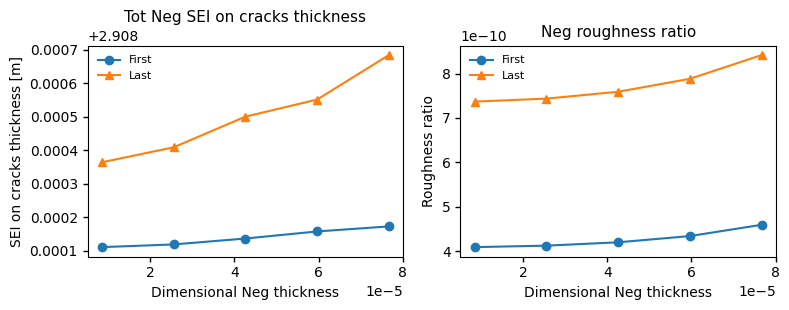

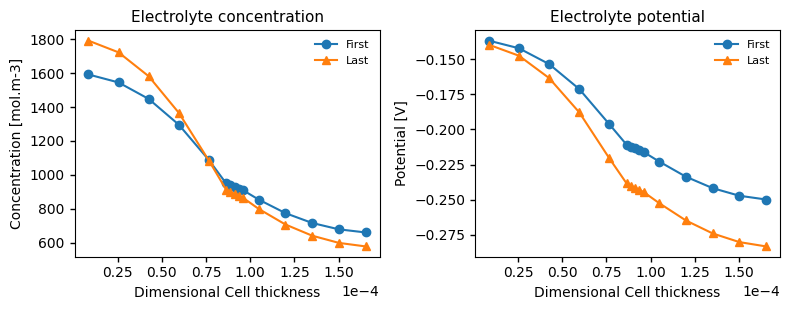

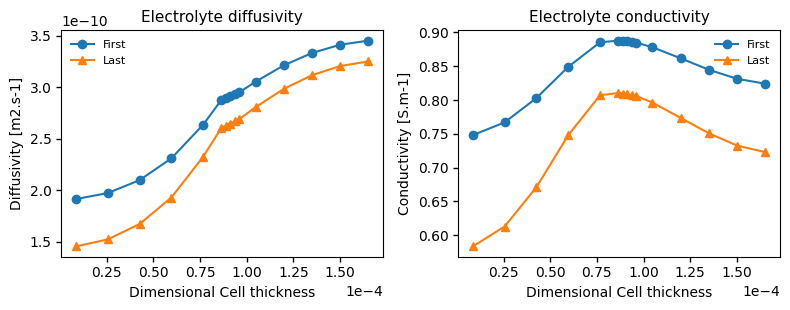

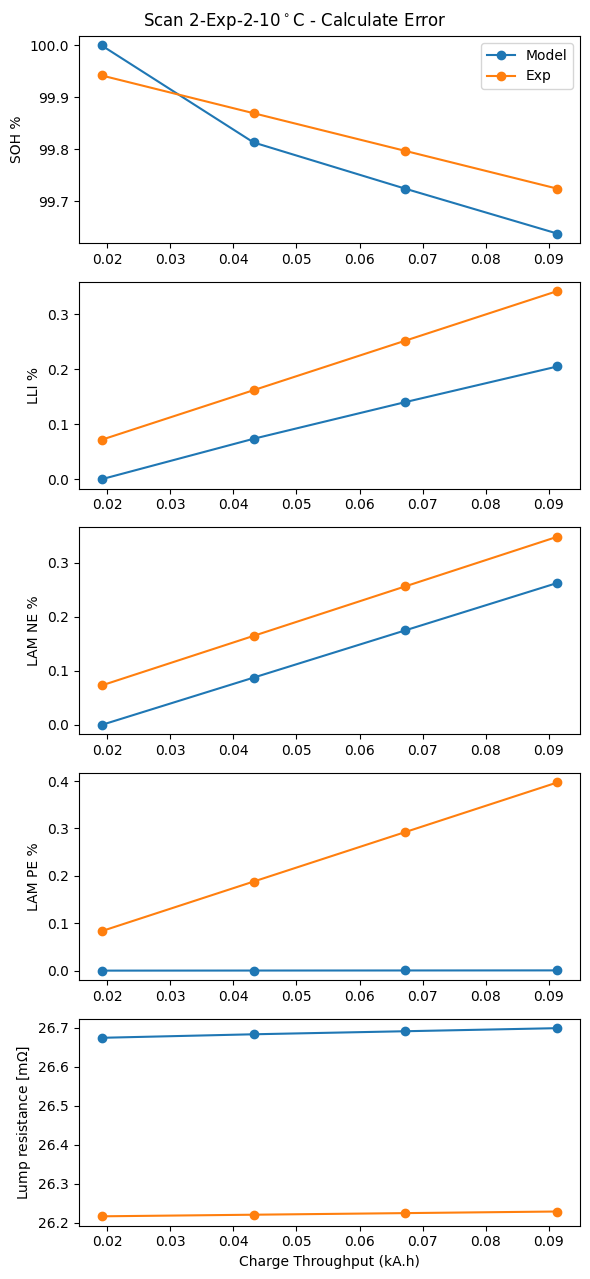

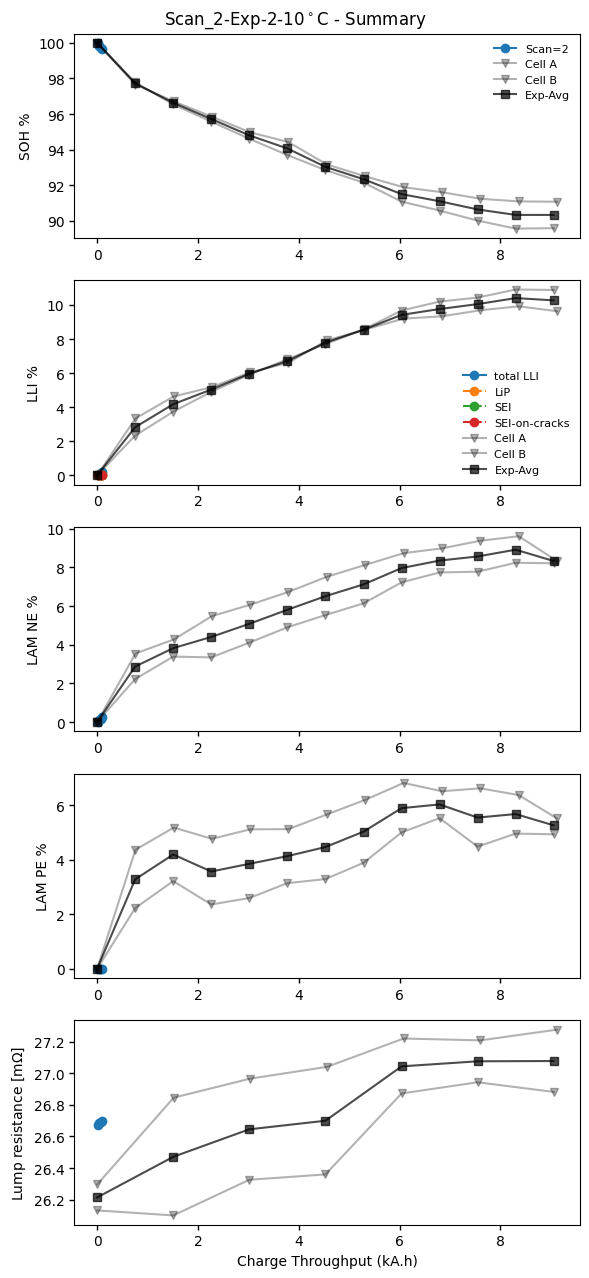

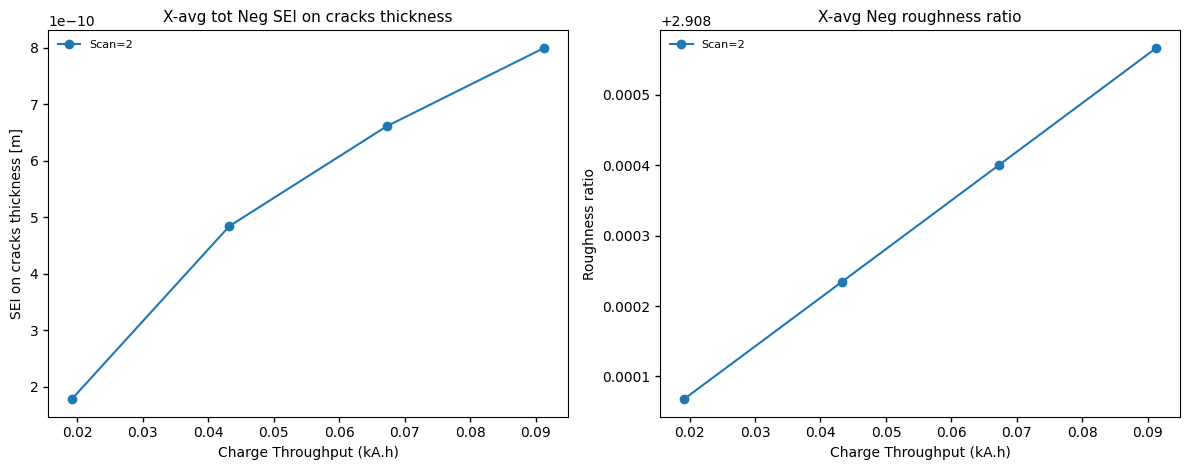

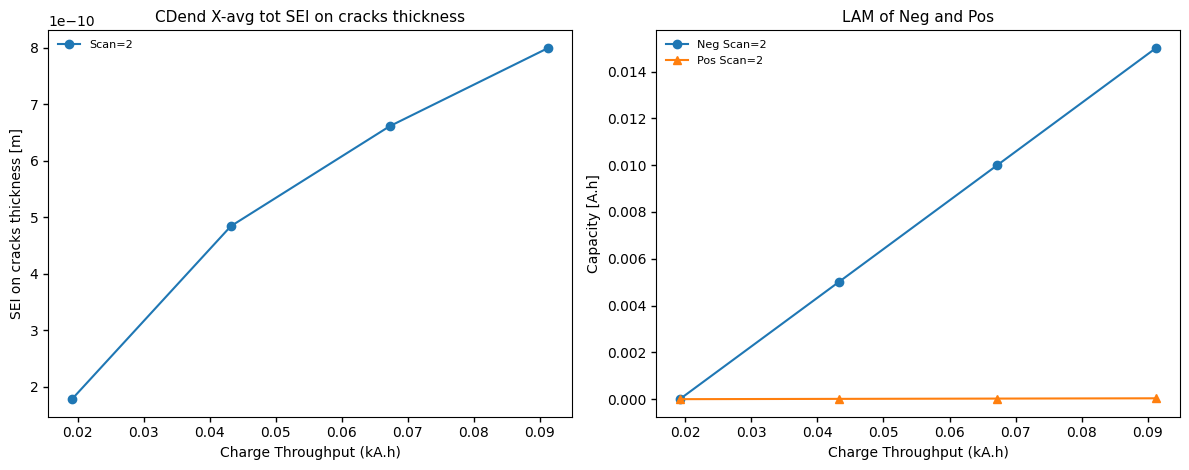

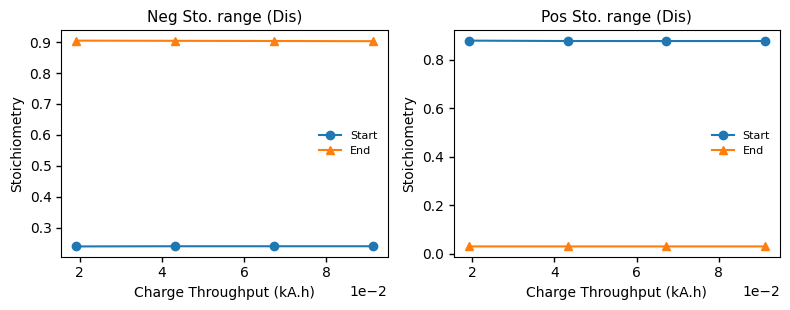

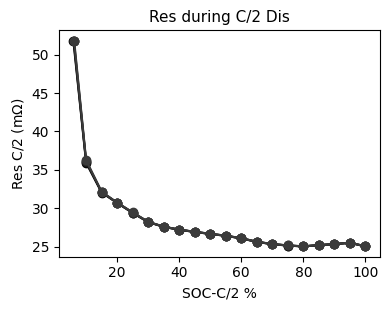

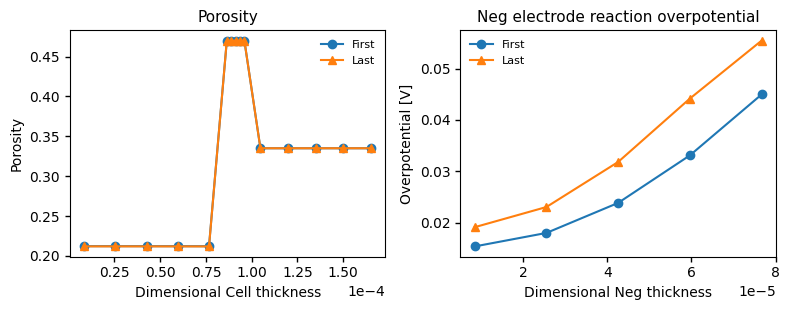

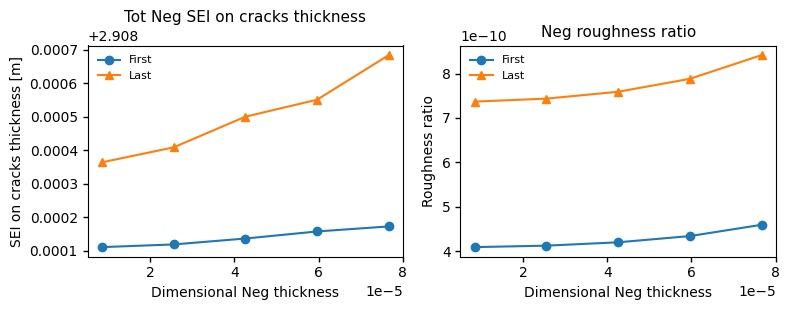

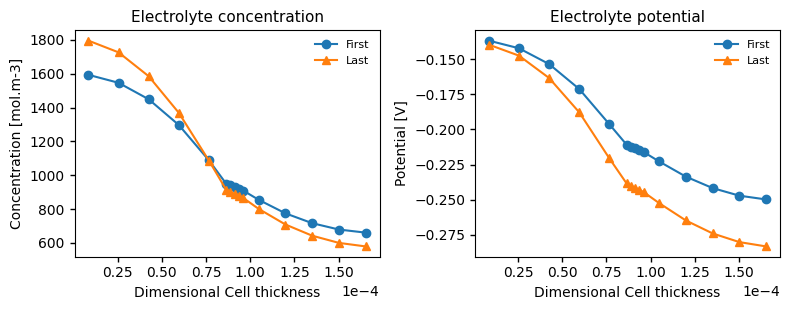

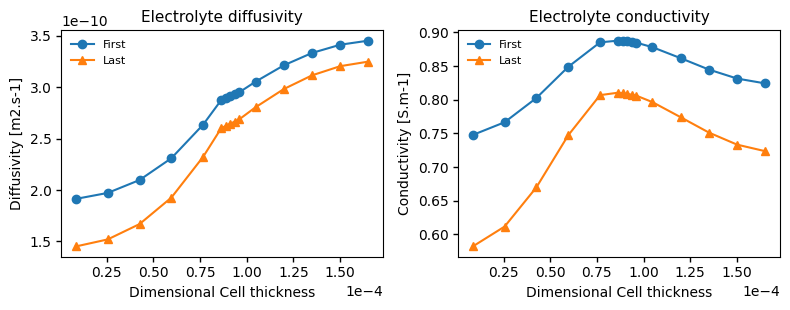

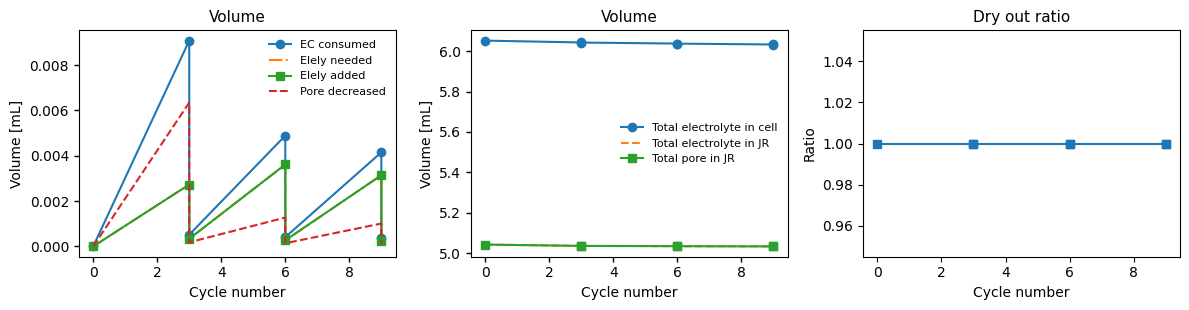

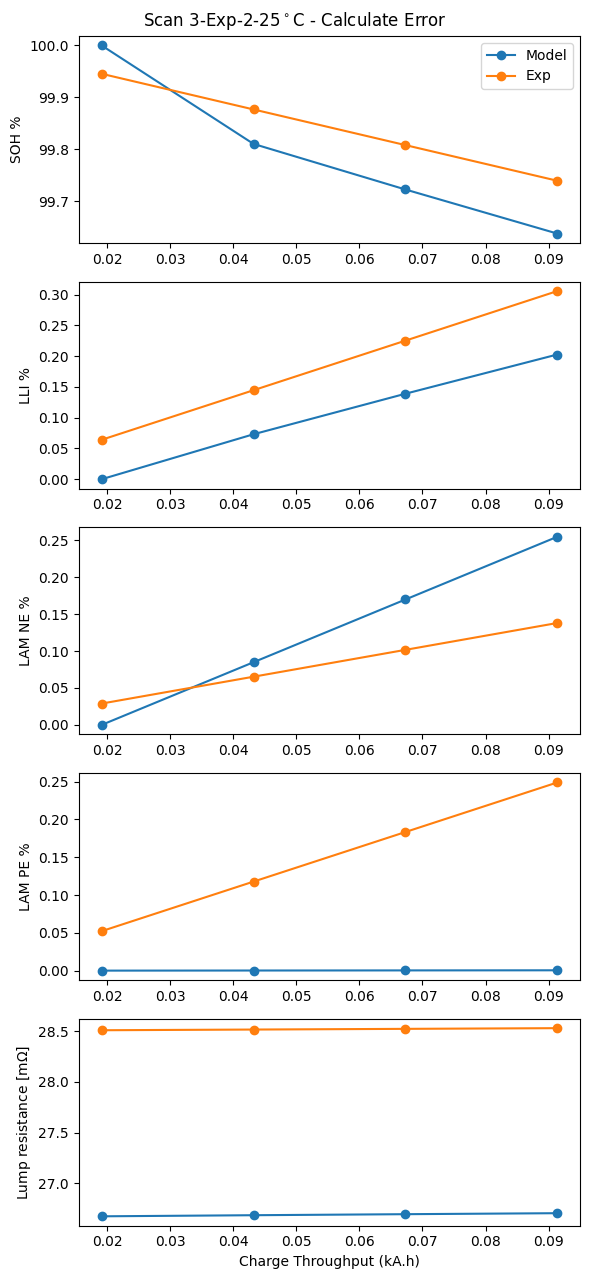

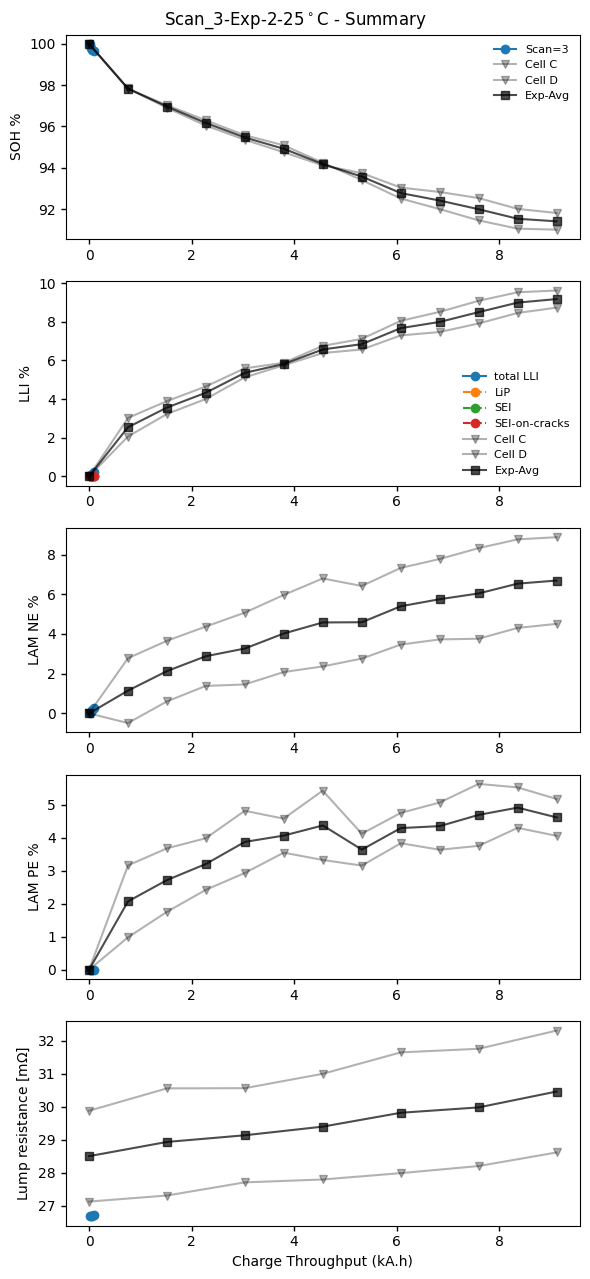

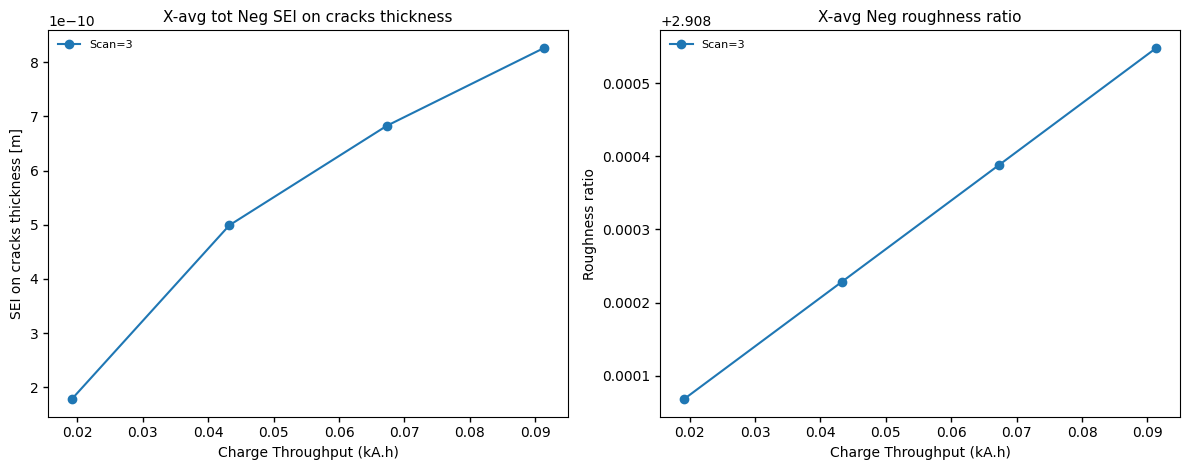

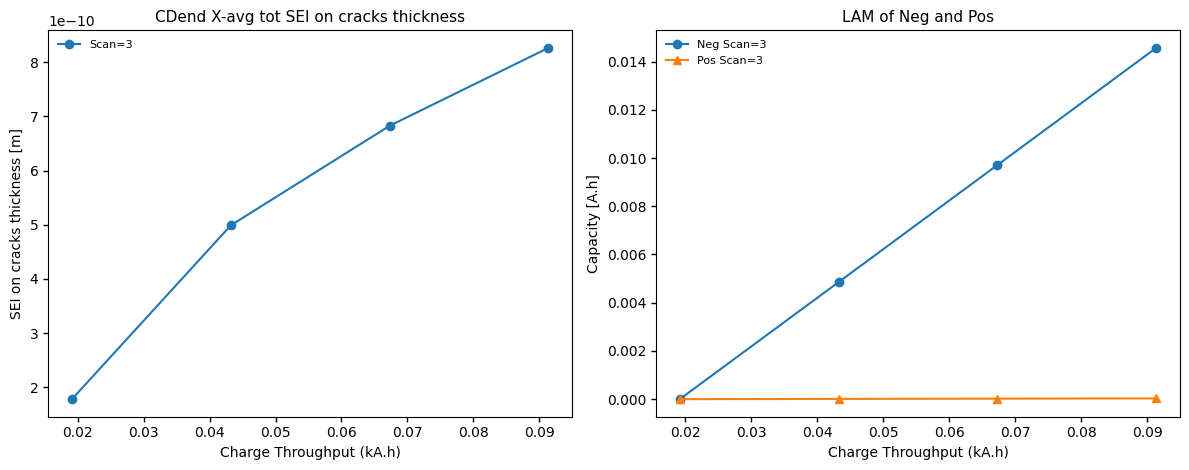

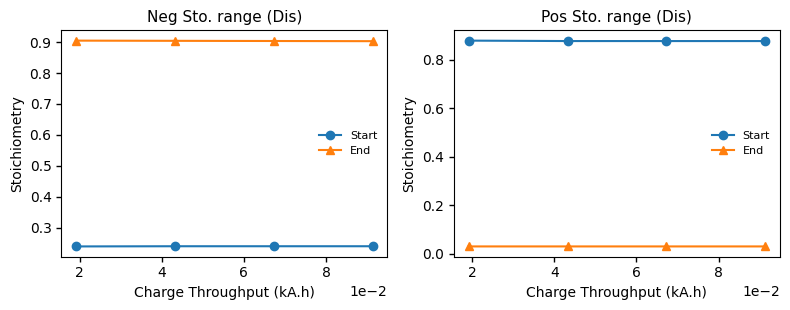

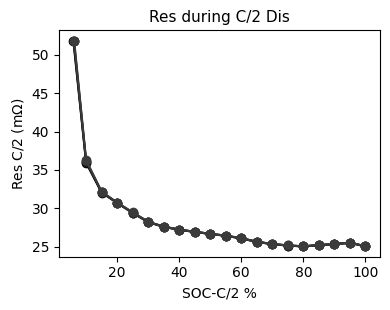

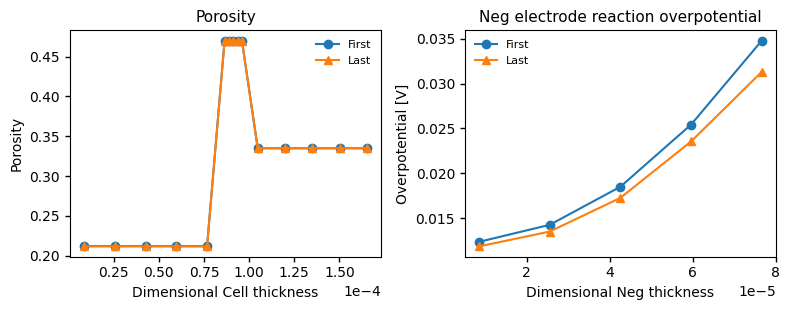

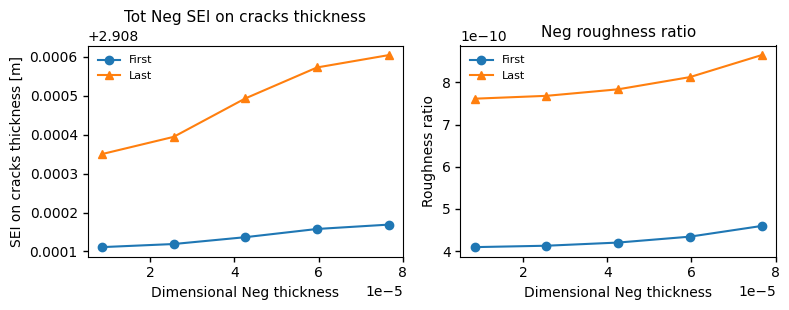

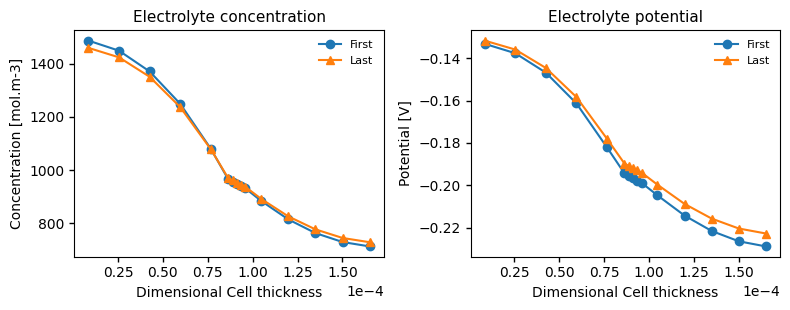

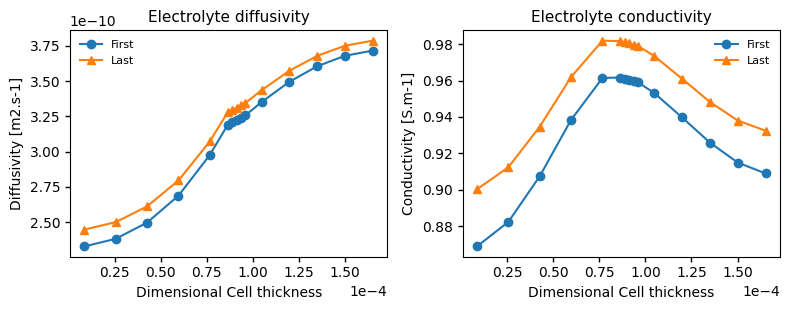

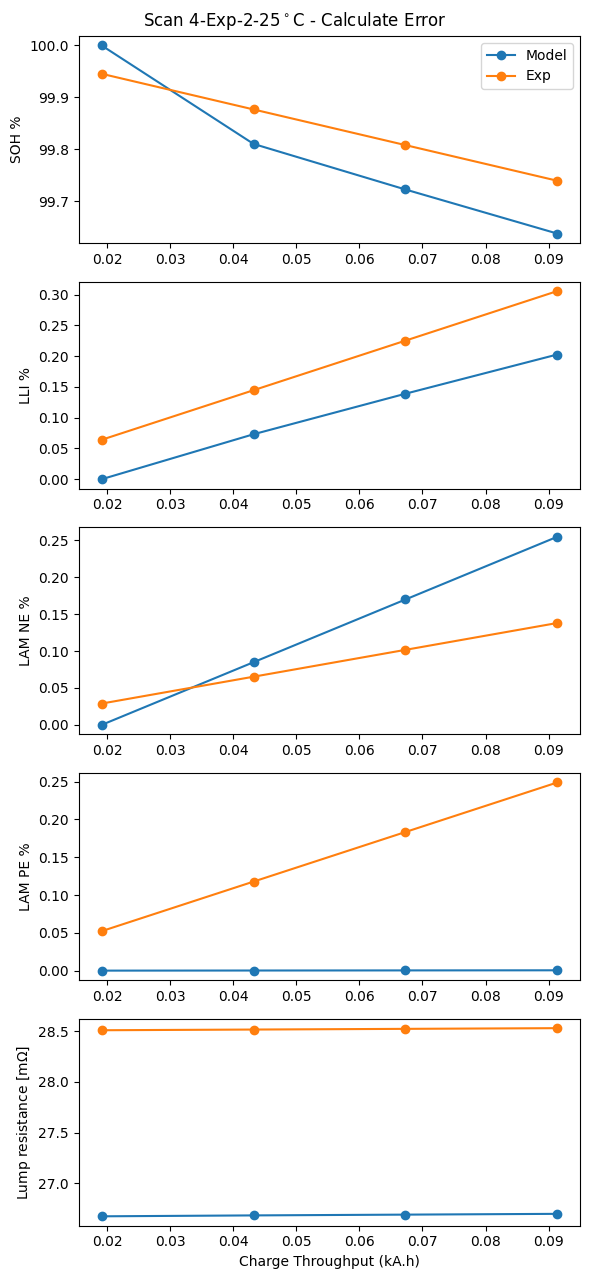

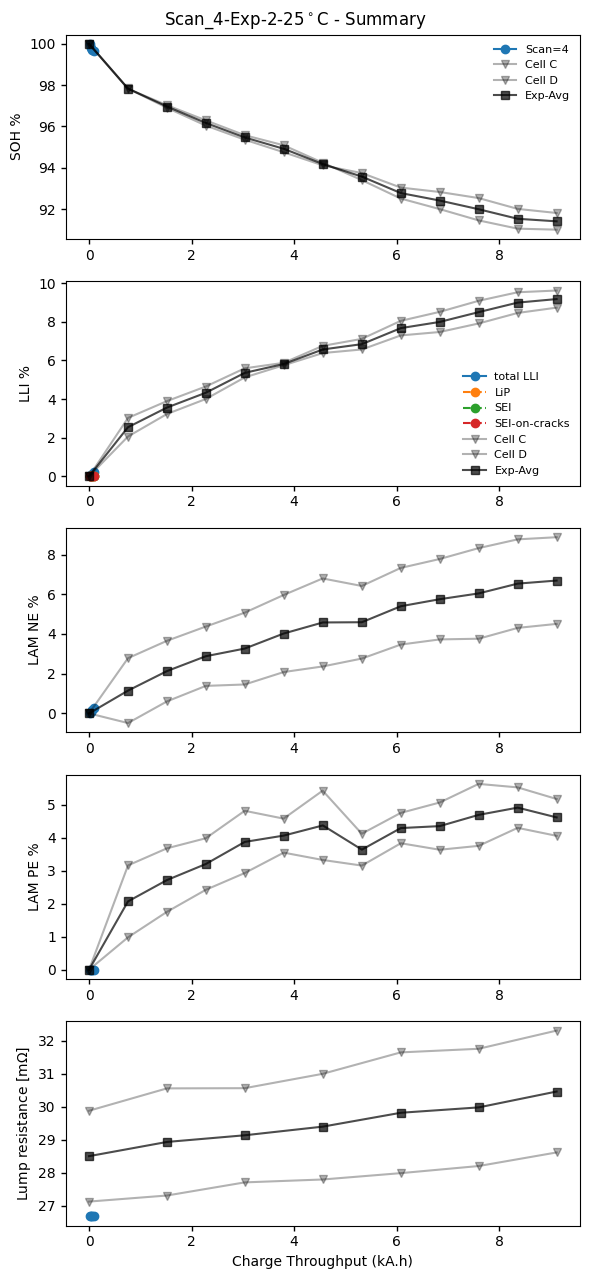

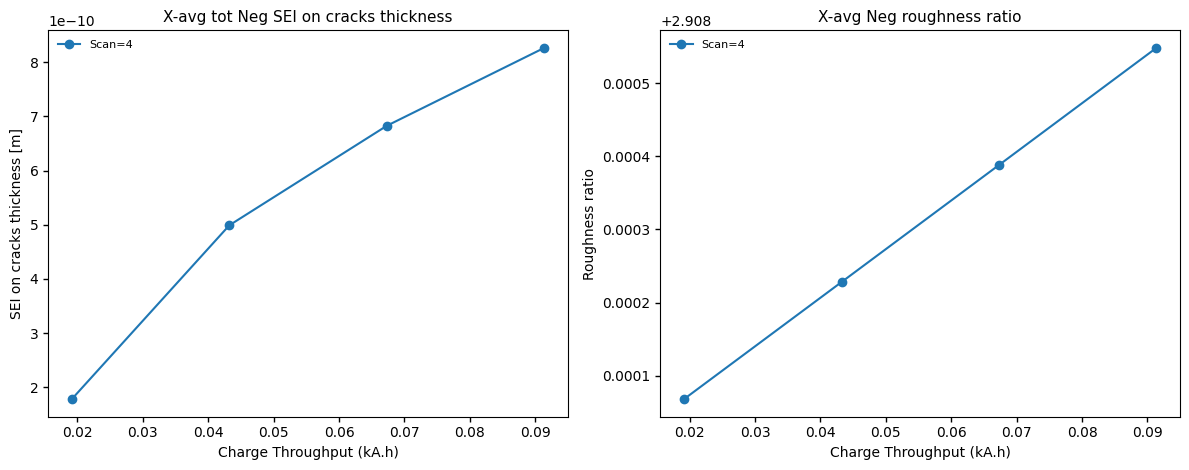

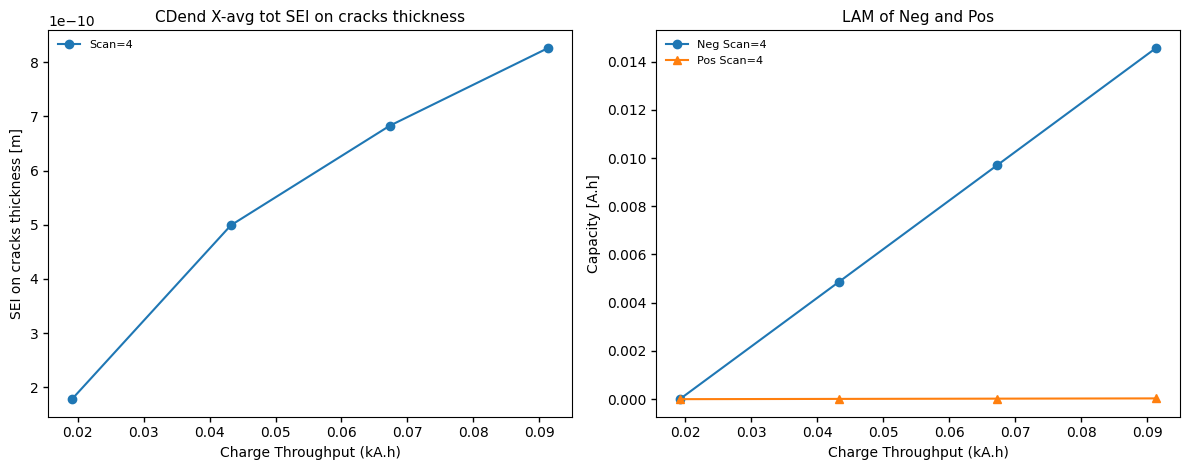

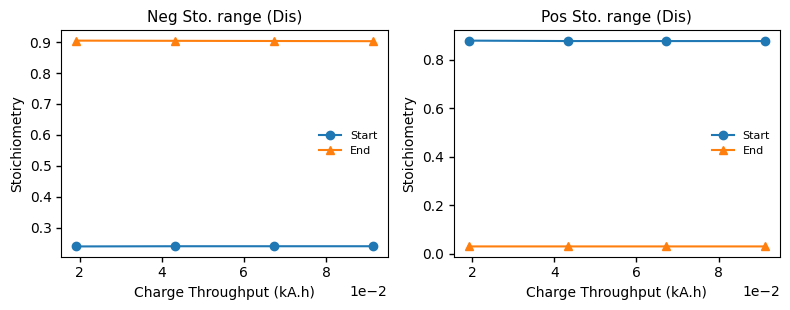

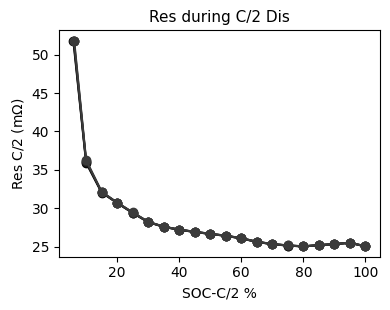

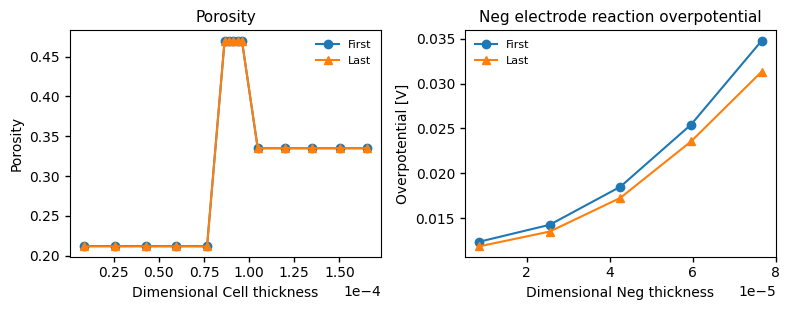

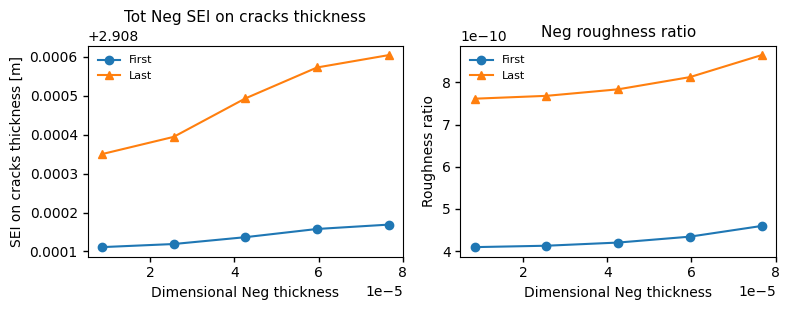

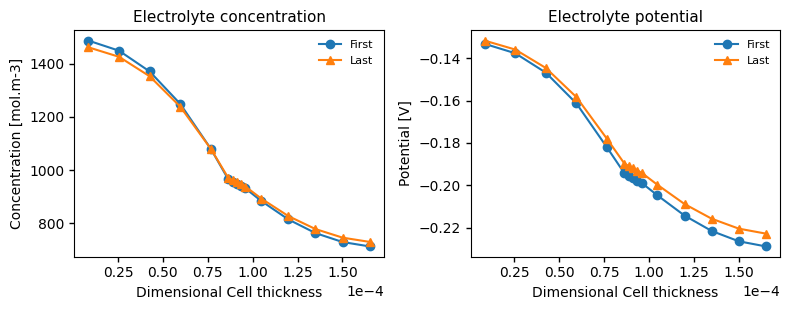

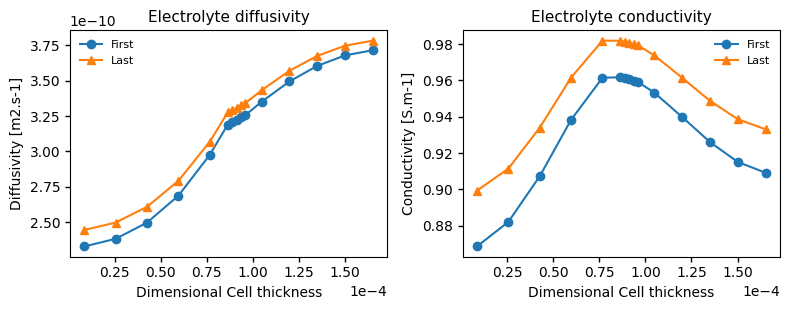

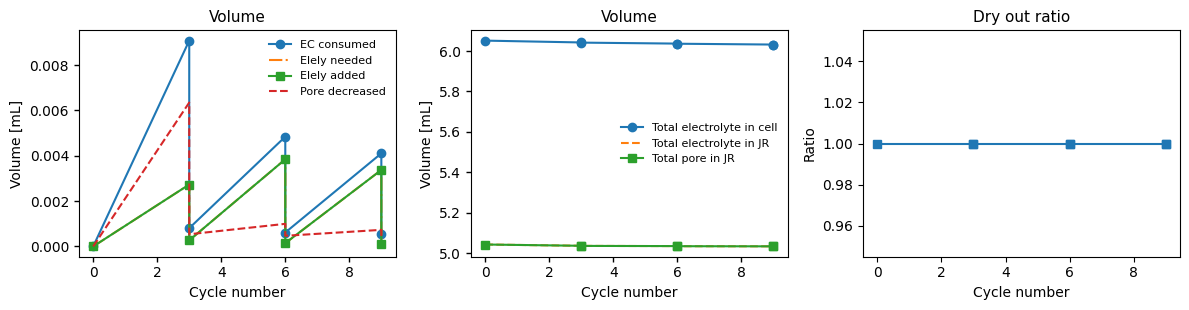

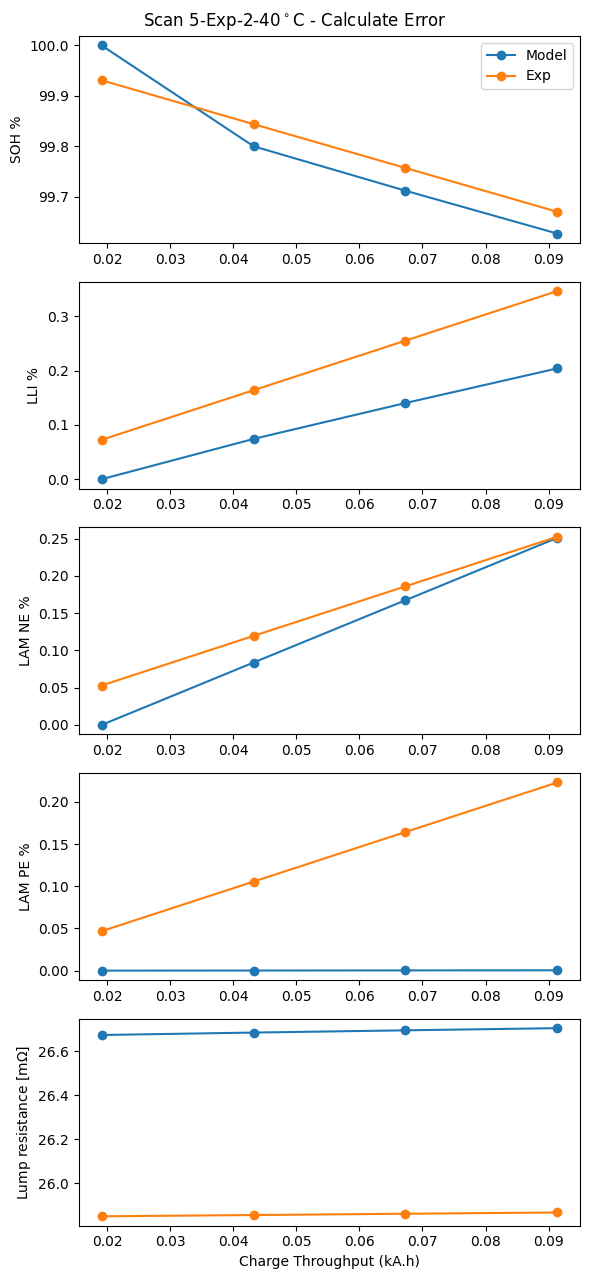

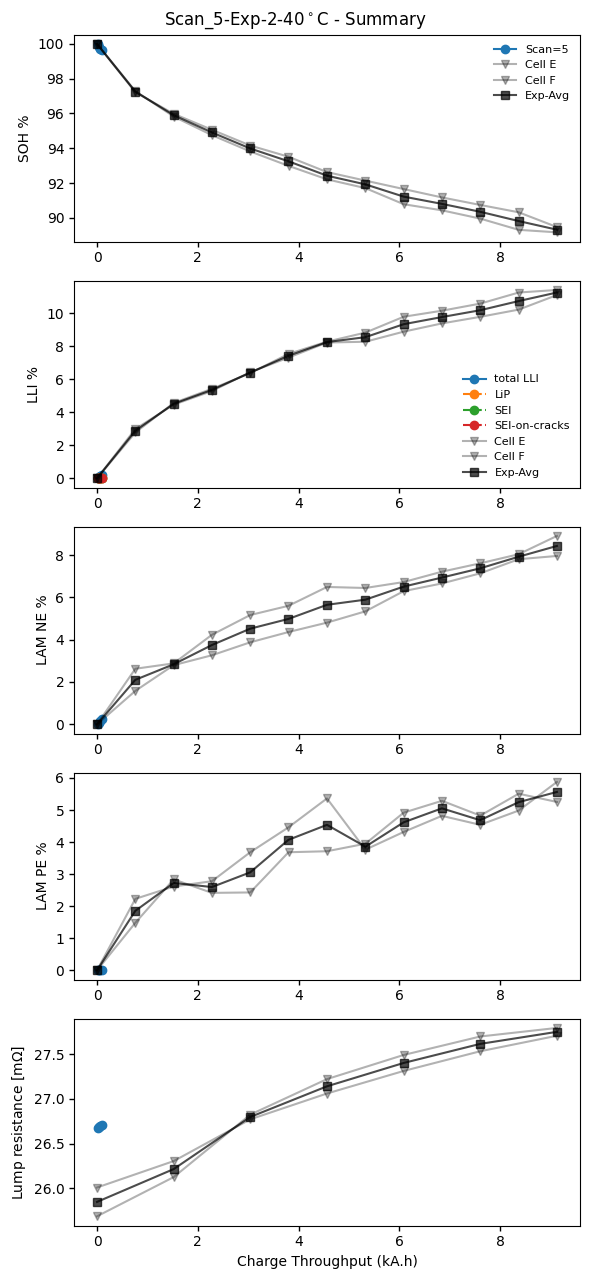

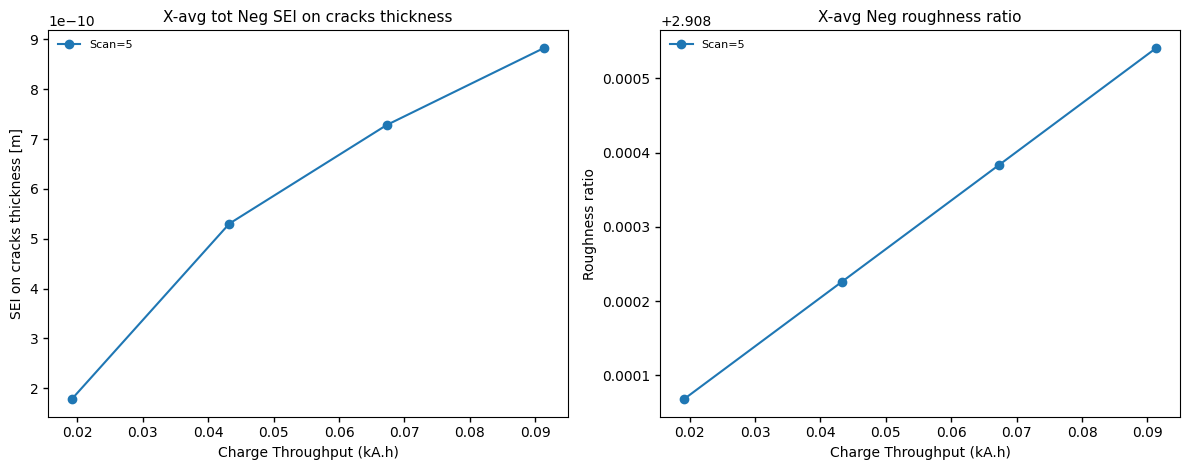

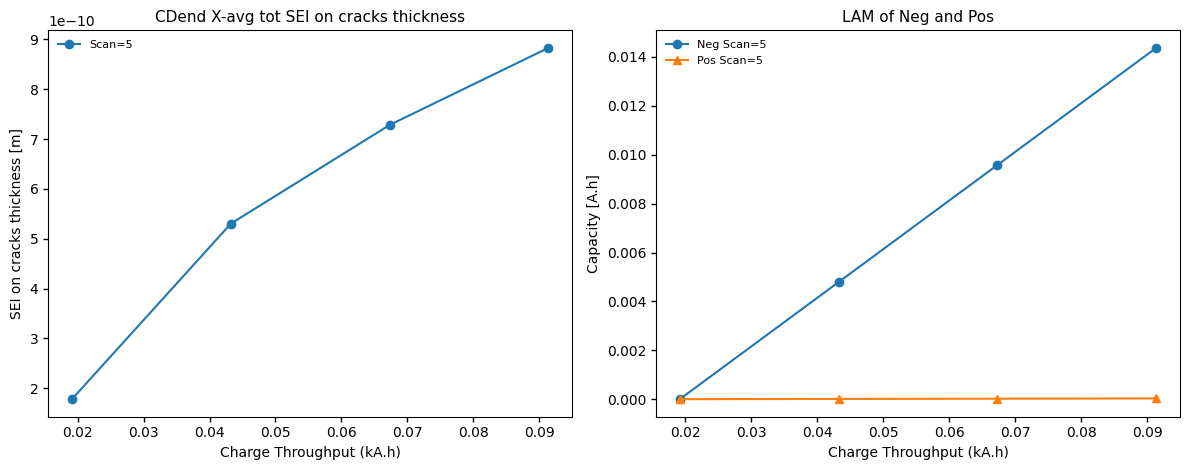

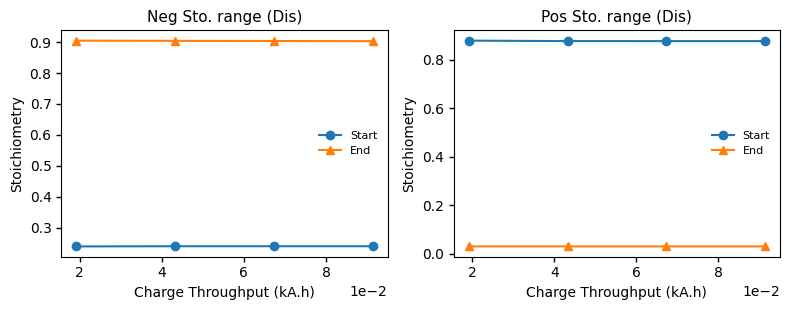

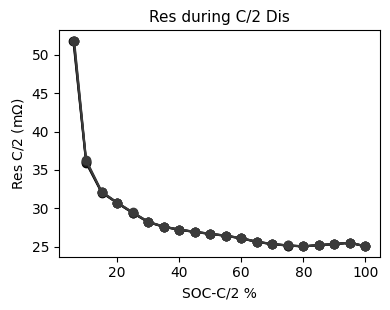

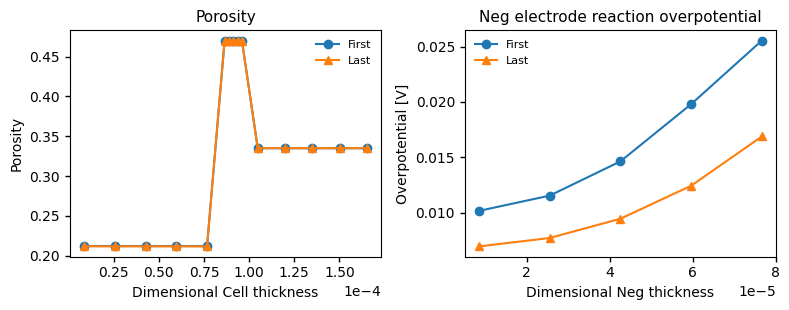

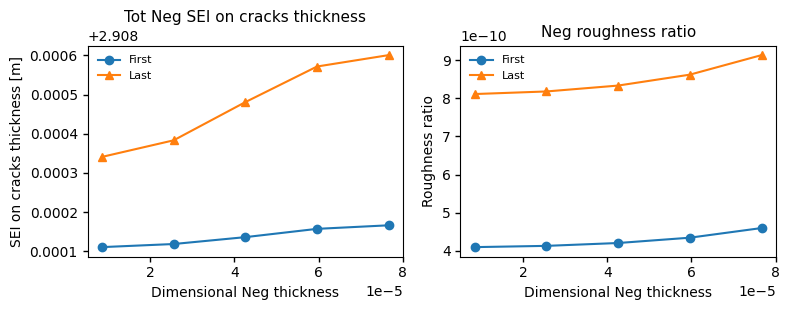

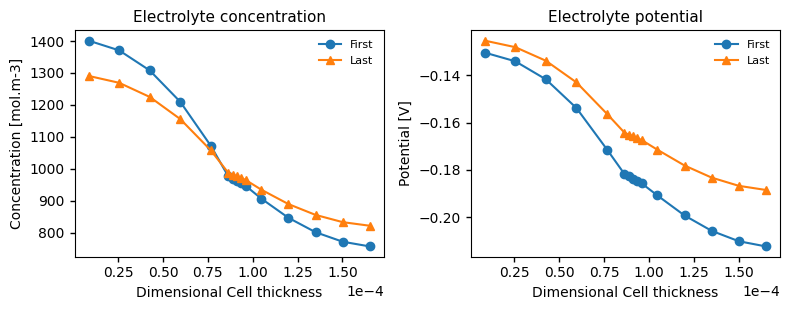

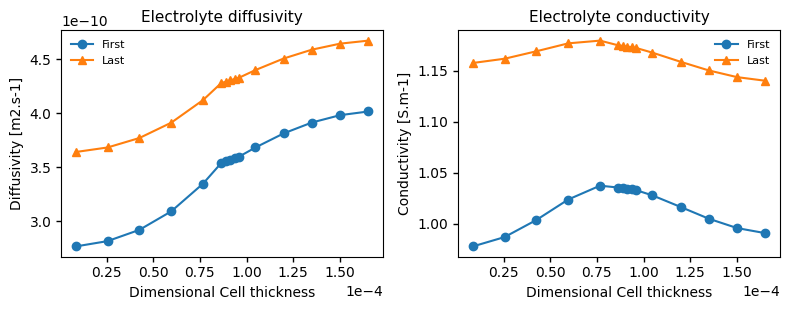

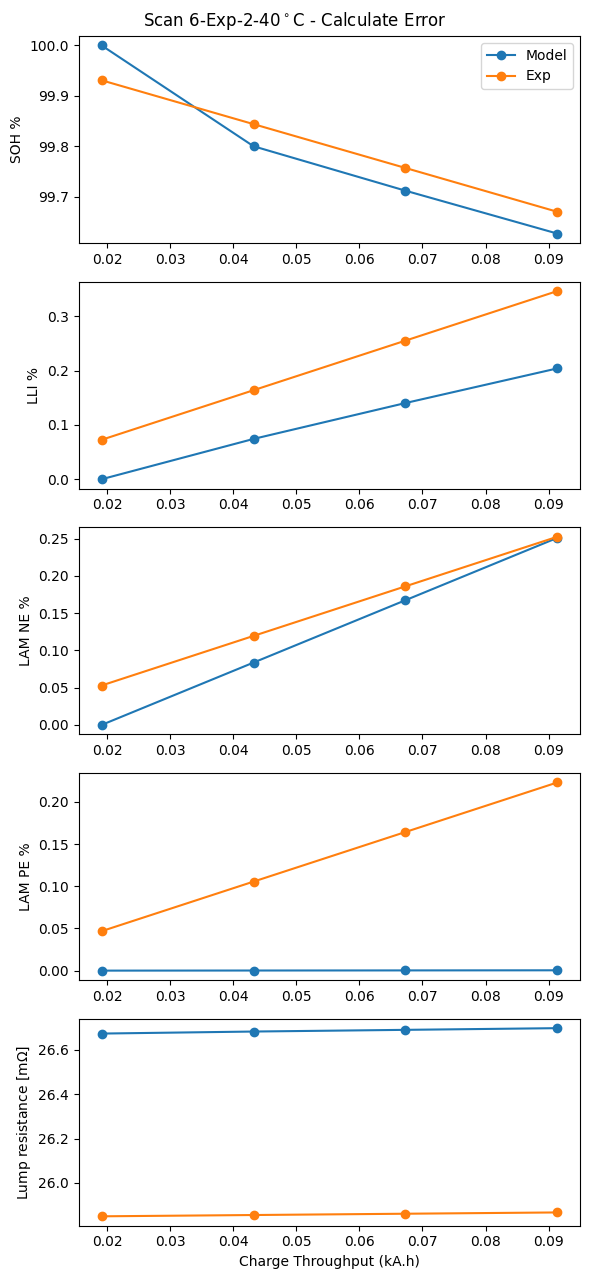

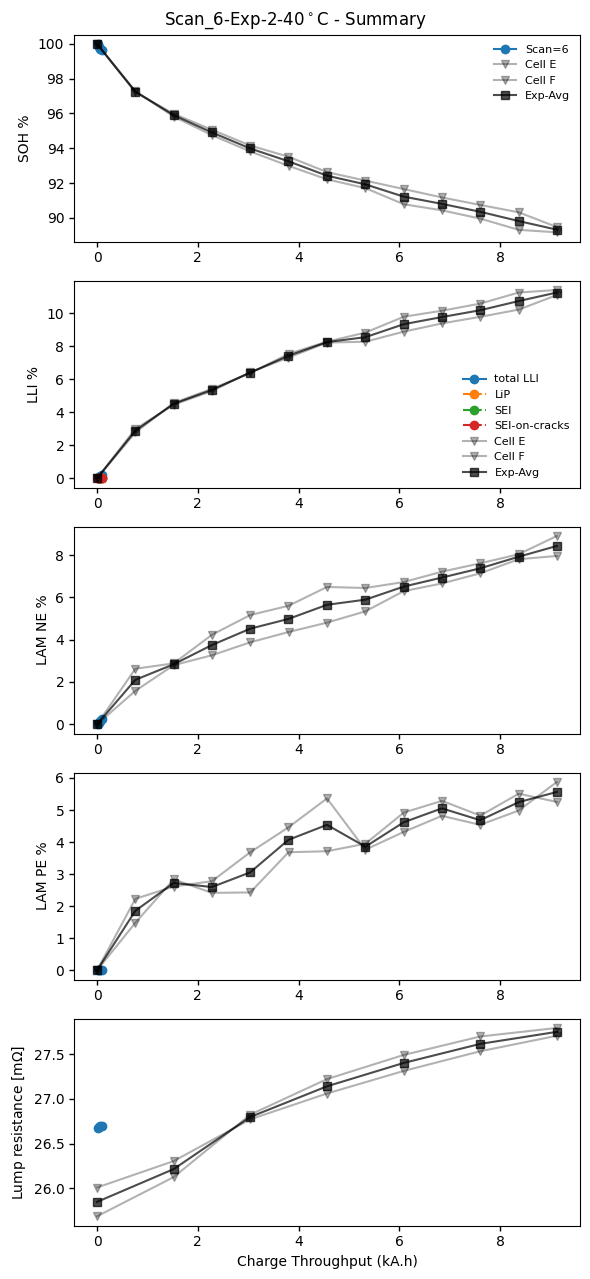

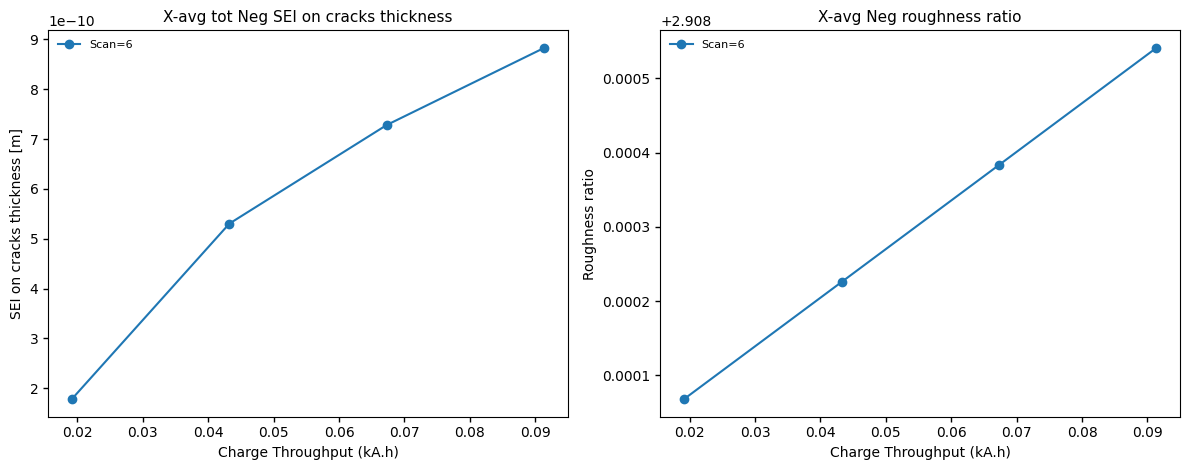

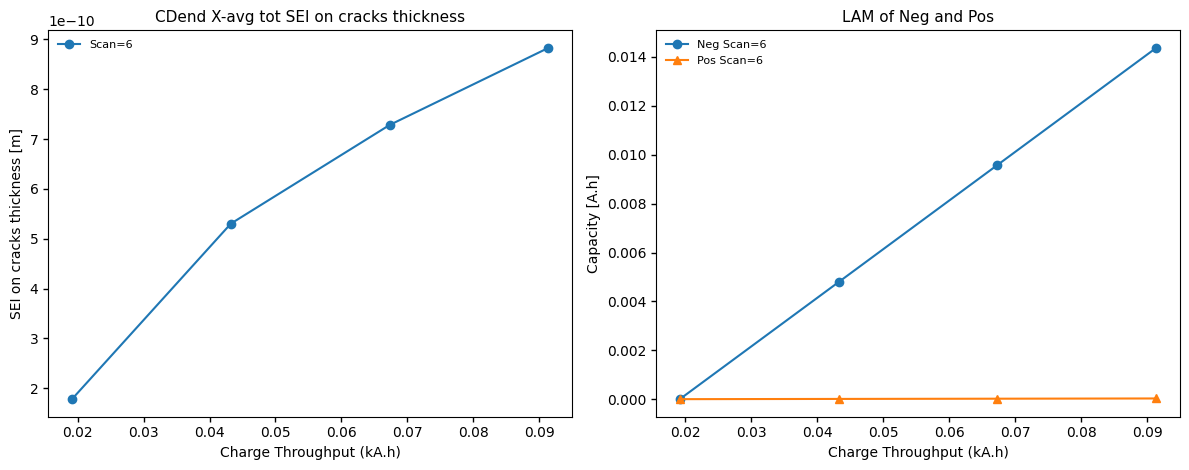

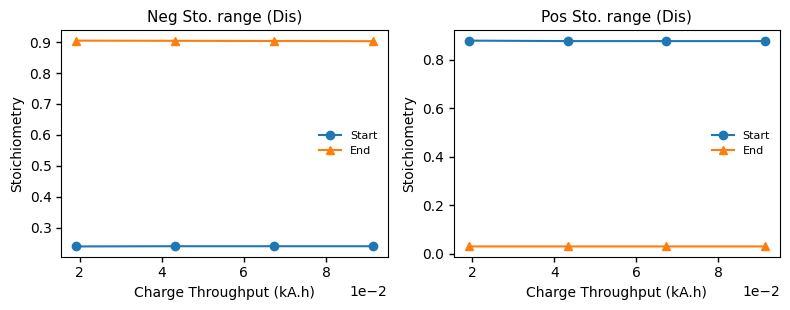

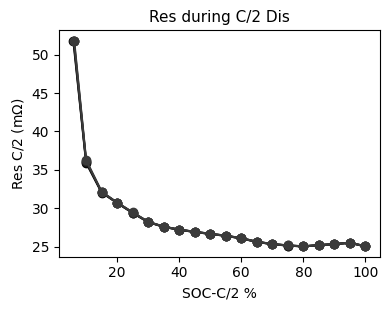

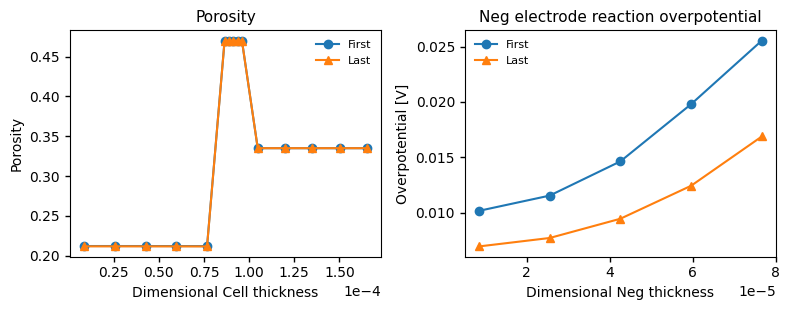

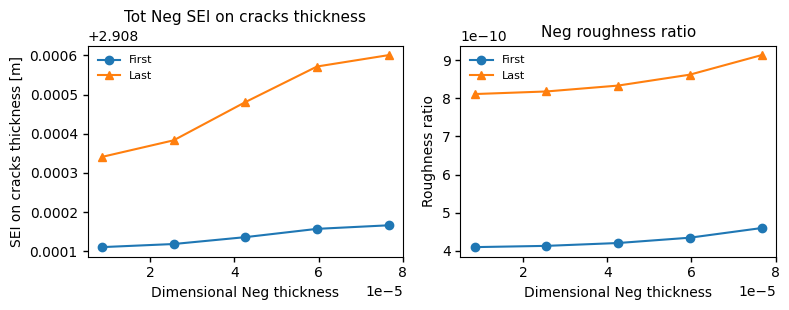

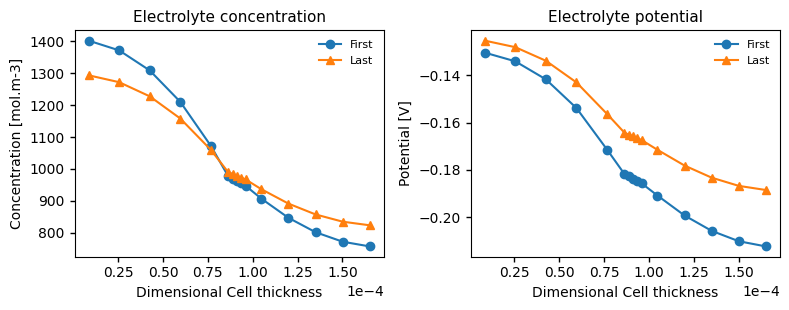

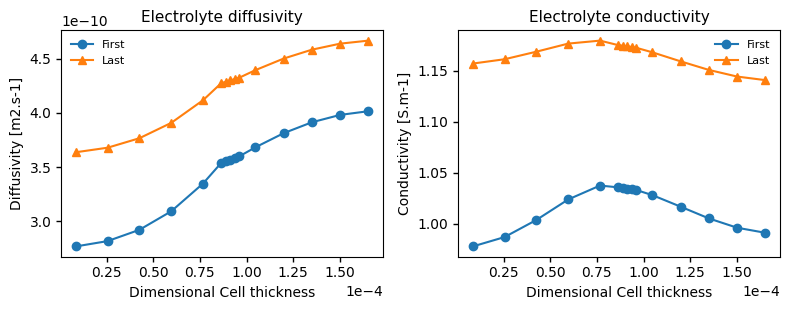

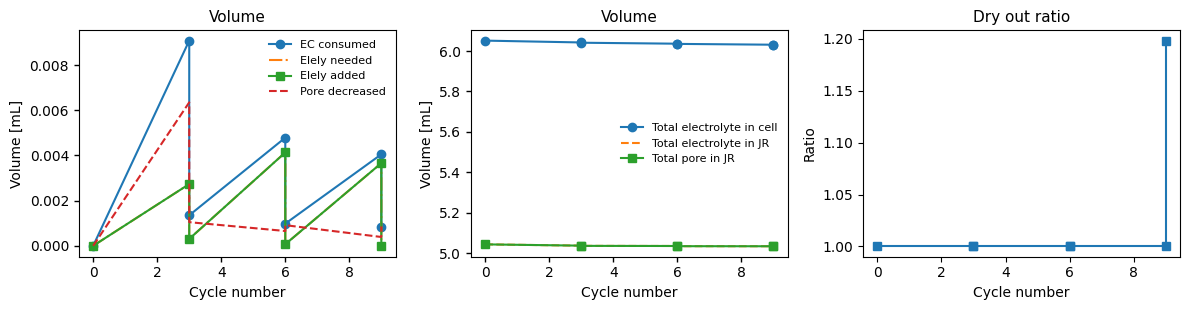

In [157]:
# scan:
fs = 10; dpi = 100;
index_list = np.arange(1,len(Para_dict_list)+1,1)
midc_merge_all = [];Sol_RPT_all = [];Sol_AGE_all = [];
for index_i, Para_dict_i in zip(index_list,Para_dict_list):
    midc_merge,Sol_RPT,Sol_AGE = Run_P2_Opt_Timeout(
        index_i    ,  index_exp,  Para_dict_i,   Path_pack, fs,
        keys_all,   exp_text_list, exp_index_pack,
        Exp_Any_AllData,Temp_Cell_Exp, dpi,
        Plot_Exp=True,Timeout=False,Return_Sol=True,Check_Small_Time=True,)  
    midc_merge_all.append(midc_merge)
    Sol_RPT_all.append(Sol_RPT)
    Sol_AGE_all.append(Sol_AGE) 

""" for index_i, Para_dict_i in zip(index_list,Para_dict_list):
    midc_merge,Sol_RPT,Sol_AGE = Run_P2_Opt_Timeout(
        index_i    ,    Para_dict_i,   Path_pack, fs,
        keys_all,   exp_text_list, exp_index_pack,
        Exp_Any_AllData,Temp_Cell_Exp,
        True,True,False,)    #Plot_Exp,  Timeout, Return_Sol  
"""
""" if __name__ == "__main__":
    pool = multiprocessing.Pool(24)
    processes = [
        pool.apply_async(
            Run_P2_Opt_Timeout, 
            args=(
                index_i, Para_dict_i,   Path_pack,fs,
                keys_all,   exp_text_list, exp_index_pack,
                Exp_Any_AllData,Temp_Cell_Exp,
                True,False,False,) #Plot_Exp,  Timeout,Return_Sol 
            ) 
            for index_i, Para_dict_i in zip(index_list,Para_dict_list)]
    result = [p.get() for p in processes]   """


i_try = 0
while i_try<3:
    try:
        getSth = Sol_0["Throughput capacity [A.h]"].entries[-1]
    except:
        i_try += 1
        print(f"Fail to read Throughput capacity for the {i_try}th time")
    else:
        break
print(getSth)

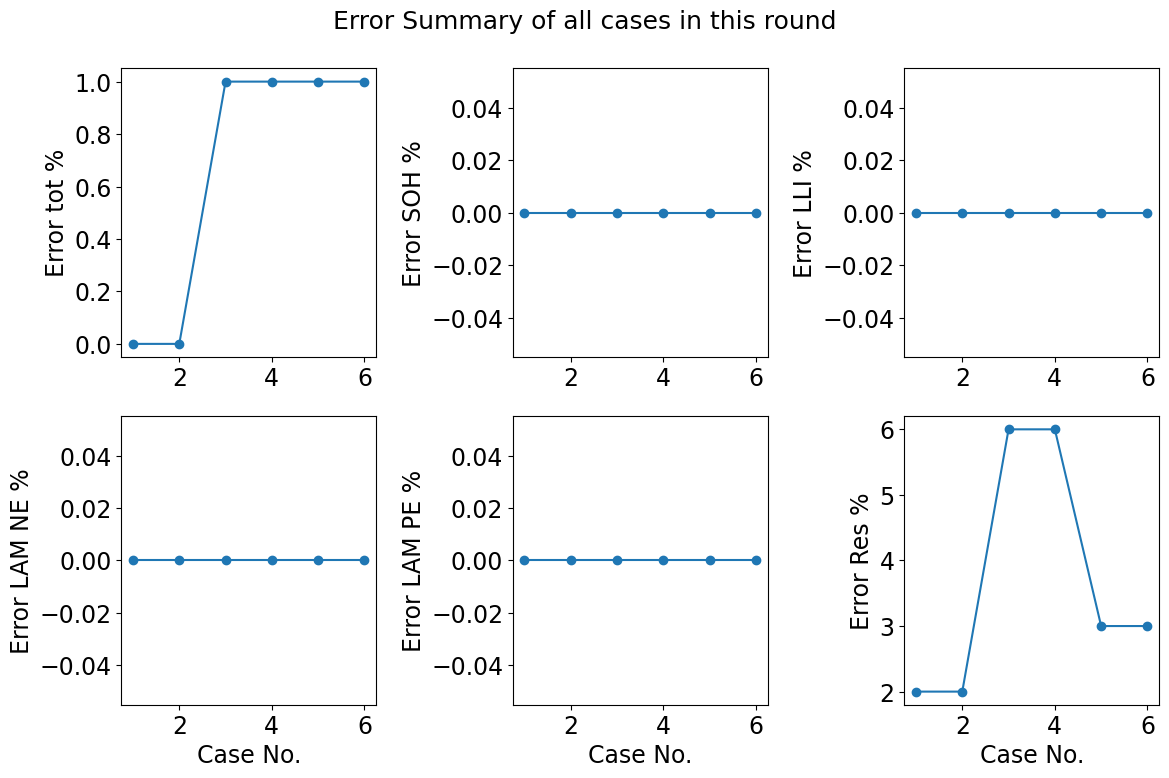

In [160]:
# After finish scans, get summary of the errors of all cases:
fs=17;
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)
Caes_Index = np.arange(1,len(midc_merge_all)+1)
Mpe_tot = []; Mpe_1 = [];Mpe_2 = []; Mpe_3 = [];Mpe_4 = []; Mpe_5 = [];
for i in range(len(midc_merge_all)):
    Mpe_tot.append(midc_merge_all[i]["Error tot %"])
    Mpe_1.append(midc_merge_all[i]["Error SOH %"])
    Mpe_2.append(midc_merge_all[i]["Error LLI %"])
    Mpe_3.append(midc_merge_all[i]["Error LAM NE %"])
    Mpe_4.append(midc_merge_all[i]["Error LAM PE %"])
    Mpe_5.append(midc_merge_all[i]["Error Res %"])
Mpe_All = [Mpe_tot,Mpe_1,Mpe_2,Mpe_3,Mpe_4,Mpe_5]
Str_All = [
    "Error tot %","Error SOH %","Error LLI %",
    "Error LAM NE %","Error LAM PE %","Error Res %"]
fig, axs = plt.subplots(2,3, figsize=(12,8),tight_layout=True)
for i in range(6):
    if i<=2: # 0,1,2
        m=0; n = i
    else:   # 3,4,5 
        m=1; n = i-3
    axs[m,n].plot( Caes_Index,  Mpe_All[i], '-o',  )
    axs[m,n].set_ylabel(Str_All[i])
    axs[1,n].set_xlabel("Case No.")
    fig.suptitle(
        f"Error Summary of all cases in this round", 
        fontsize=fs+1)
plt.savefig(
    BasicPath + Target+
    f"0!_Error Summary of all cases in this round.png", dpi=600)
plt.savefig(
    BasicPath + Target+
    f"0!_Error Summary of all cases in this round.svg")

In [159]:
Index_List_succeed = index_list
for index_i in Index_List_succeed:
    #print(index_i)
    try:
        old_book = str(index_i) + '_' + book_name_xlsx
        #print(old_book)
        #open excel:
        data_old = openpyxl.load_workbook(
            BasicPath + Target+ "Excel/" + old_book)   
        data_tar = openpyxl.load_workbook(
            BasicPath + Target + book_name_xlsx) 

        table_old = data_old[str(index_i)]
        nrows_old = table_old.max_row  # 获得行数
        ncolumns_old = table_old.max_column  # 获得列数

        table_tar = data_tar[sheet_name_xlsx]
        nrows_tar = index_i # Mark!!! Most important changes!
        ncolumns_old = table_old.max_column  # 获得列数
        list_old = [];
        #print(nrows_old,nrows_tar)
        for i in range(1,nrows_old+1):
            for j in range(1,ncolumns_old+1):
                list_old.append(table_old.cell(row=i,column=j).value)
        
        list_old = [list_old,]
        for i in range(1, len(list_old)+1):
                for j in range(1, len(list_old[i-1])+1):
                    #print(i,j,list_old[i-1][j-1]    )
                    table_tar.cell(nrows_tar+i, j).value = list_old[i-1][j-1]     
        data_tar.save(BasicPath + Target + book_name_xlsx) 
        data_tar.close()
    except:
        print(f"Something goes wrong for Scan {index_i}!")
    else:
        print(f"Successfuly write results for Scan {index_i}!") 


Successfuly write results for Scan 1!
Successfuly write results for Scan 2!
Successfuly write results for Scan 3!
Successfuly write results for Scan 4!
Successfuly write results for Scan 5!
Successfuly write results for Scan 6!
